## Customer Segmentation By Wanxin :)

### Let's import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats

### Load the survey_users_app_usage dataset and check the duplicates

In [2]:
app_df = pd.read_csv('survey_users_app_usage.csv').drop(["Unnamed: 12"], axis= 1)

In [3]:
app_df['user_id'].duplicated().any()

True

Ohno we have some ambiguous duplicates, but the don't have clear clarification of them :(

In [4]:
# the same user id has the different start_date and app usage(need more clarifications)
app_df[app_df['user_id']=='35cf0fe172c911e9a690dca9049399ef']

user_id duolingo_start_date  daily_goal  \
6048  35cf0fe172c911e9a690dca9049399ef        4/3/22 19:58        50.0   
6132  35cf0fe172c911e9a690dca9049399ef        12/6/20 4:57         NaN   

      highest_course_progress took_placement_test  purchased_subscription  \
6048                     14.0                True                   False   
6132                     -7.0                True                   False   

      highest_crown_count  n_active_days  n_lessons_started  \
6048                 61.0             50              517.0   
6132                305.0             95             4786.0   

      n_lessons_completed  longest_streak  n_days_on_platform  
6048                397.0              21                  54  
6132               4686.0             169                 537

In [5]:
# to remove the duplicate, we drop the row of duplicated user_id with earlier 'duolingo_start_date'
app_df['duolingo_start_date'] = pd.to_datetime(app_df['duolingo_start_date'])
app_df = app_df.sort_values(by='duolingo_start_date')
app_df = app_df.drop_duplicates(subset='user_id', keep='first')

### Load the survey_data dataset and check the duplicates

In [6]:
survery_df = pd.read_csv('survey_data.csv')

In [7]:
survery_df['user_id'].duplicated().any()

True

In [8]:
# many user took the survey for two times 
# below is a example that a user filled in totaly different information for the survey(why?)
# see the feature 'age' and 'country'
survery_df[survery_df['user_id']=='35cb11f872c911e9aac3dca9049399ef']

user_id          age      annual_income  \
6025  35cb11f872c911e9aac3dca9049399ef        18-34       $0 - $10,000   
6059  35cb11f872c911e9aac3dca9049399ef  75 or older  $11,000 - $25,000   

     country duolingo_platform                      duolingo_subscriber  \
6025      RU       Web browser  No, I have never paid for Duolingo Plus   
6059      FR    iPhone or iPad   Yes, I currently pay for Duolingo Plus   

     duolingo_usage   employment_status future_contact             gender  \
6025          Daily          Unemployed             No  Prefer not to say   
6059          Daily  Employed part-time            Yes               Male   

     other_resources                        primary_language_commitment  \
6025       Textbooks  I'm moderately committed to learning this lang...   
6059   Private tutor  I'm moderately committed to learning this lang...   

                                primary_language_review  \
6025  I am using Duolingo to learn this language for...   
6059  I am using Duolingo to review a language I've ...   

                           primary_language_motivation  \
6025  I want to advance professionally or economically   
6059    I want to connect with my heritage or identity   

                   primary_language_motivation_followup  \
6025  Learning this language will be useful in my cu...   
6059                                                NaN   

     primary_language_proficiency                  student  survey_complete  \
6025                     Beginner  Not currently a student                1   
6059                 Intermediate                      NaN                1   

      time_spent_seconds  
6025                 497  
6059                 484

In [9]:
# drop duplicates while keeping the last entry
# because I assume the last row is the latest survey that the user filled, which represents more accurate info
survery_df = survery_df.drop_duplicates(subset='user_id', keep='last')

### Join these two dataset together by inner join

In [10]:
original_df = pd.merge(app_df, survery_df, on = 'user_id', how = 'inner')

drop: user_id, duolingo_start_date, other_resources, primary_language_motivation_followup

ordinal encoding: age, annual_income, primary_language_commitment, primary_language_proficiency

one hot encoding: country, took_placement_test, duolingo_platform, duolingo_subscriber, duolingo_usage, employment_status, future_contact, gender(impute na with prefer not to say), primary_language_review,primary_language_motivation, student

binary encoding: purchased_subscription

numeric variable: daily_goal(0 for na), highest_course_progress(0 for na), highest_crown_count(0 for na), n_active_days, n_lessons_started(0 for na), n_lessons_completed(0 for na), longest_streak, n_days_on_platform, time_spent_seconds

In [11]:
original_df.shape

(6079, 30)

In [12]:
original_df['user_id'].duplicated().any()

False

The merged dataset has 6079 distinct users and total 30 features.

## EDA

I first drop some columns.

In [13]:
df_user_id = original_df['user_id']
df = original_df.drop(['user_id', 'duolingo_start_date', 'other_resources', 'primary_language_motivation_followup'], axis=1)

**Bar plot for categorical data:**

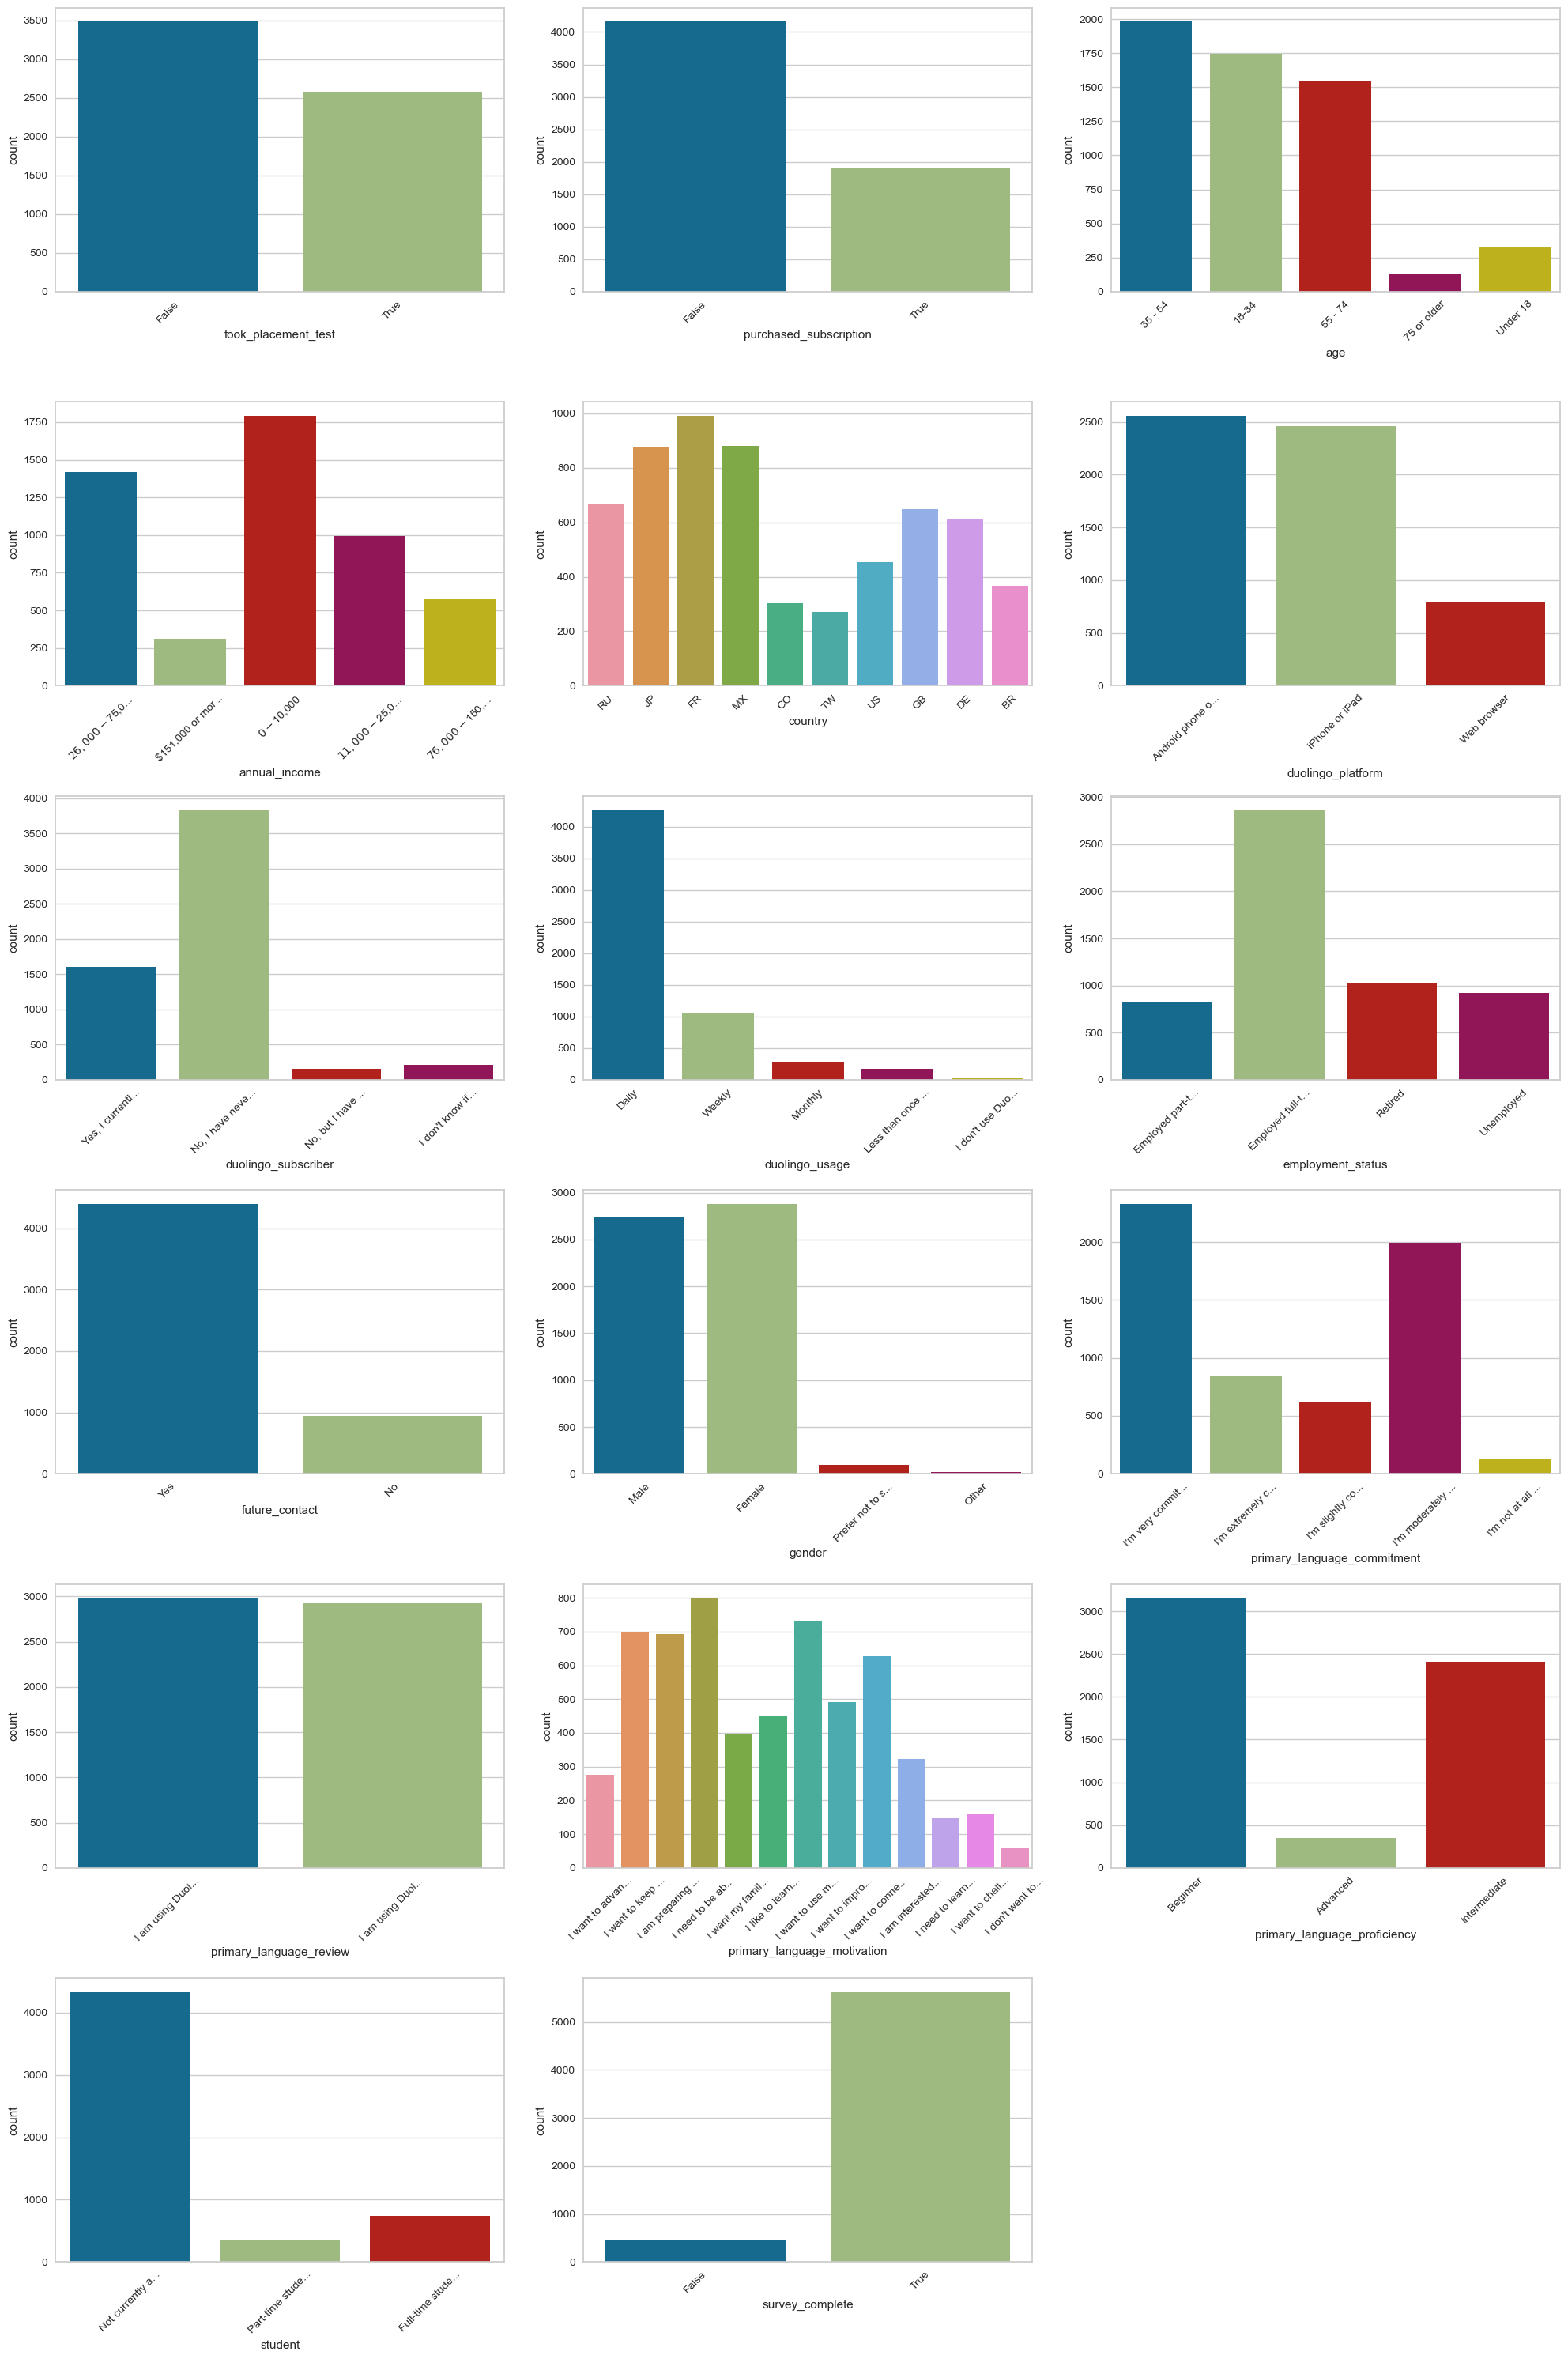

In [14]:
df['survey_complete'] = df['survey_complete'].astype(bool)

def truncate_label(text, max_length=15):
    if len(text) > max_length:
        return text[:max_length] + '...'  
    else:
        return text

categorical_columns = df.select_dtypes(include=['object', 'bool']).columns

n_cols = 3  
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  
axes = axes.flatten()  

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_xticklabels([truncate_label(label.get_text()) for label in axes[i].get_xticklabels()], rotation=45)

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Distribution for numeric variables:**

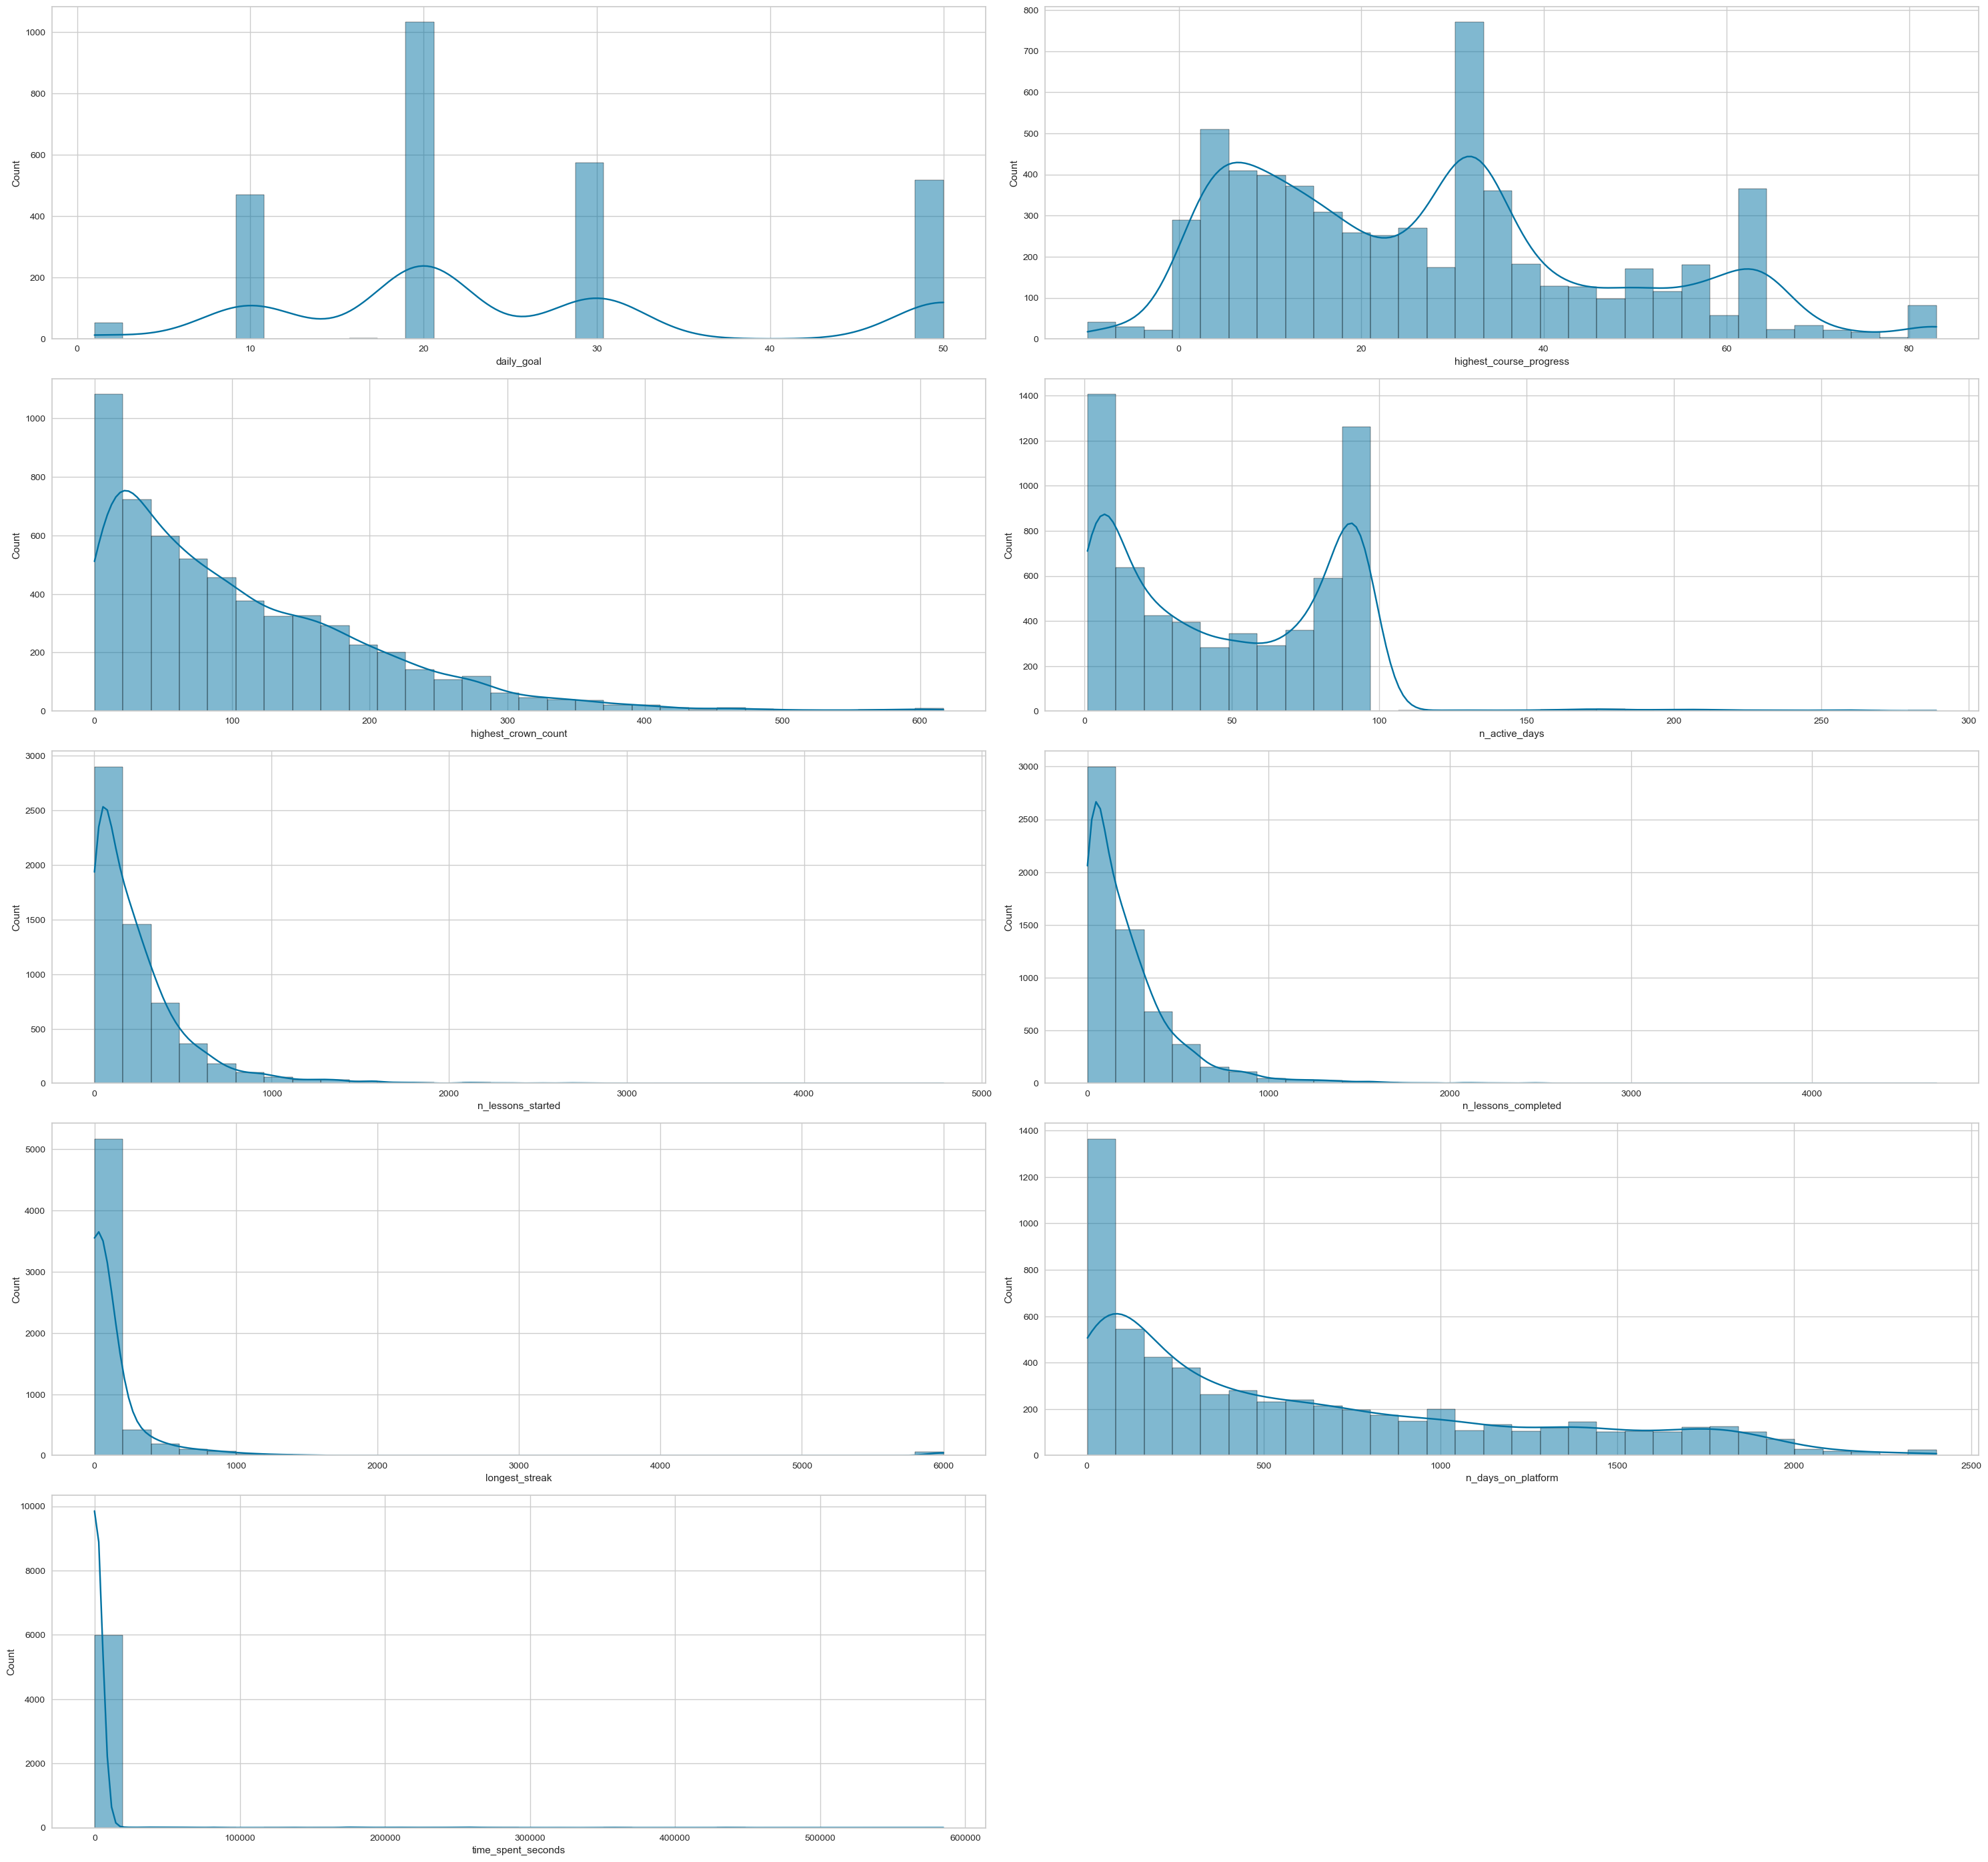

In [15]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

n_cols = 2 
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 50))  
axes = axes.flatten() 

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    plt.title(f'Distribution of {col}')

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Data Preprocessing

**drop**: user_id, duolingo_start_date, other_resources, primary_language_motivation_followup

**ordinal encoding**: age, annual_income, primary_language_commitment, primary_language_proficiency

**one hot encoding**: country, took_placement_test, duolingo_platform, duolingo_subscriber, duolingo_usage, employment_status, future_contact, gender(impute na with prefer not to say), primary_language_review,primary_language_motivation, student

**binary encoding**: purchased_subscription, survey_complete

**numeric variable**: daily_goal(0 for na), highest_course_progress(0 for na), highest_crown_count(0 for na), n_active_days, n_lessons_started(0 for na), n_lessons_completed(0 for na), longest_streak, n_days_on_platform, time_spent_seconds

In [16]:
# For numeric variables
columns_to_fill = ['daily_goal', 'highest_course_progress', 'highest_crown_count', 'n_lessons_started', 'n_lessons_completed']
for column in columns_to_fill:
    df[column] = df[column].fillna(0)

In [17]:
# For gender, impute null valuw with 'Prefer not to say'
df['gender'] = df['gender'].fillna('Prefer not to say')

In [18]:
# Calculate the proportion of null values in the remaining features
null_proportions = df.isna().mean() * 100
null_proportions_df = null_proportions.reset_index()
null_proportions_df.columns = ['Feature', 'Percentage of Null Values']
null_proportions_df[null_proportions_df['Percentage of Null Values'] != 0]

Feature  Percentage of Null Values
2            took_placement_test                   0.230301
10                           age                   5.625925
11                 annual_income                  16.236223
13             duolingo_platform                   4.425070
14           duolingo_subscriber                   4.573121
15                duolingo_usage                   4.408620
16             employment_status                   7.353183
17                future_contact                  12.025004
19   primary_language_commitment                   2.648462
20       primary_language_review                   2.780063
21   primary_language_motivation                   3.832867
22  primary_language_proficiency                   2.566212
23                       student                  10.708998

For feature with percentage of missing values less than 10%, it is safe to use imputation by mode, and then apply one-hot encoding and ordinal encoding.

In [19]:
df['took_placement_test'] = df['took_placement_test'].fillna(df['took_placement_test'].mode()[0])
df['age'] = df['age'].fillna(df['age'].mode()[0])
df['duolingo_platform'] = df['duolingo_platform'].fillna(df['duolingo_platform'].mode()[0])
df['duolingo_subscriber'] = df['duolingo_subscriber'].fillna(df['duolingo_subscriber'].mode()[0])
df['duolingo_usage'] = df['duolingo_usage'].fillna(df['duolingo_usage'].mode()[0])
df['employment_status'] = df['employment_status'].fillna(df['employment_status'].mode()[0])
df['primary_language_commitment'] = df['primary_language_commitment'].fillna(df['primary_language_commitment'].mode()[0])
df['primary_language_review'] = df['primary_language_review'].fillna(df['primary_language_review'].mode()[0])
df['primary_language_motivation'] = df['primary_language_motivation'].fillna(df['primary_language_motivation'].mode()[0])
df['primary_language_proficiency'] = df['primary_language_proficiency'].fillna(df['primary_language_proficiency'].mode()[0])

In [20]:
df['annual_income'] = df['annual_income'].fillna('Unknown')
df['future_contact'] = df['future_contact'].fillna('Unknown')
df['student'] = df['student'].fillna('Unknown')

In [21]:
#specify all the columns
numeric_feats = ["daily_goal","highest_course_progress","highest_crown_count",'n_active_days',"n_lessons_started",
                 "n_lessons_completed","longest_streak", 'n_days_on_platform', 'time_spent_seconds'] 
ordinal_feats_1 = ['age']
ordinal_feats_2 = ['primary_language_commitment']
ordinal_feats_3 = ['primary_language_proficiency']
categorical_feats = ['country', 'took_placement_test', 'duolingo_platform', 'duolingo_subscriber', 'duolingo_usage', 
                     'employment_status', 'gender', 'primary_language_review','primary_language_motivation', "annual_income", 'future_contact', 'student']
passthrough_feats = ['survey_complete', 'purchased_subscription'] 

#specify the ordinal
age_level = ['Under 18','18-34','35 - 54','55 - 74','75 or older']
commitment_level = [
       "I'm not at all committed to learning this language.",
       "I'm slightly committed to learning this language.",
       "I'm moderately committed to learning this language.",
       "I'm very committed to learning this language.",
       "I'm extremely committed to learning this language."]
proficiency_level = ['Beginner','Intermediate','Advanced']

#make a column transformer
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  
    (make_pipeline(OrdinalEncoder(categories=[age_level], dtype=int),StandardScaler(with_mean=False)), ordinal_feats_1), 
    (make_pipeline(OrdinalEncoder(categories=[commitment_level], dtype=int),StandardScaler(with_mean=False)), ordinal_feats_2),
    (make_pipeline(OrdinalEncoder(categories=[proficiency_level], dtype=int),StandardScaler(with_mean=False)), ordinal_feats_3),
    (make_pipeline(OneHotEncoder(handle_unknown="ignore"),StandardScaler(with_mean=False)), categorical_feats),
    ("passthrough", passthrough_feats))
df_transformed = ct.fit_transform(df)

In [22]:
df_transformed = ct.fit_transform(df)

feature_names = []

for transformer_info in ct.transformers_:
    transformer_name, transformer, columns = transformer_info
    
    if transformer == 'drop':
        continue
    elif transformer == 'passthrough':
        feature_names.extend(columns)
    else:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns
        
        feature_names.extend(names)

df_transformed = pd.DataFrame(df_transformed, columns=feature_names)

In [23]:
df_transformed

daily_goal  highest_course_progress  highest_crown_count  n_active_days  \
0      -0.717870                 0.432039             0.284511      -0.744124   
1       2.467203                 1.817486             1.102828       1.014686   
2      -0.717870                -0.013284            -0.012129       1.142136   
3      -0.717870                 0.184637            -0.226937      -0.310794   
4      -0.717870                 1.322684             0.325427       5.067596   
...          ...                      ...                  ...            ...   
6074   -0.717870                -1.250291            -1.014567      -1.202944   
6075   -0.717870                -0.310165            -0.656553      -1.177454   
6076   -0.717870                -0.211205            -0.656553      -1.177454   
6077   -0.717870                -1.151330            -0.912277      -1.177454   
6078    0.556159                -1.200810            -0.983880      -1.177454   

      n_lessons_started  n_lessons_completed  longest_streak  \
0             -0.646227            -0.656740       -0.248474   
1              0.175457             0.228821        0.153718   
2             -0.482558            -0.476086        0.442175   
3             -0.352291            -0.334396       -0.194080   
4              0.522836             0.359883       -0.227046   
...                 ...                  ...             ...   
6074          -0.739752            -0.731127       -0.248474   
6075          -0.729732            -0.716958       -0.246826   
6076          -0.706351            -0.699247       -0.248474   
6077          -0.616166            -0.610691       -0.246826   
6078          -0.709691            -0.695705       -0.245178   

      n_days_on_platform  time_spent_seconds       age  ...  \
0               2.997354           -0.106641  2.188369  ...   
1               2.993994           -0.120893  1.094185  ...   
2               2.975519           -0.104518  1.094185  ...   
3               2.963761           -0.112933  1.094185  ...   
4               2.962082           -0.111265  1.094185  ...   
...                  ...                 ...       ...  ...   
6074           -1.033731           -0.106603  2.188369  ...   
6075           -1.033731           -0.117254  2.188369  ...   
6076           -1.033731           -0.106224  2.188369  ...   
6077           -1.033731           -0.112440  1.094185  ...   
6078           -1.033731           -0.118467  2.188369  ...   

      annual_income_Unknown  future_contact_No  future_contact_Unknown  \
0                       0.0           0.000000                     0.0   
1                       0.0           0.000000                     0.0   
2                       0.0           0.000000                     0.0   
3                       0.0           0.000000                     0.0   
4                       0.0           0.000000                     0.0   
...                     ...                ...                     ...   
6074                    0.0           2.755119                     0.0   
6075                    0.0           0.000000                     0.0   
6076                    0.0           0.000000                     0.0   
6077                    0.0           0.000000                     0.0   
6078                    0.0           0.000000                     0.0   

      future_contact_Yes  student_Full-time student  \
0               2.236148                   0.000000   
1               2.236148                   0.000000   
2               2.236148                   0.000000   
3               2.236148                   0.000000   
4               2.236148                   0.000000   
...                  ...                        ...   
6074            0.000000                   0.000000   
6075            2.236148                   0.000000   
6076            2.236148                   0.000000   
6077            2.236148                   3.065495   
6078         

In [24]:
df_transformed.shape

(6079, 74)

The transformed dataset contains 74 features.

## PCA for dimension reduction

Since we have total 74 features after the data preprocessing, we first conduct the PCA to reduce the dimension for future k means clustering.

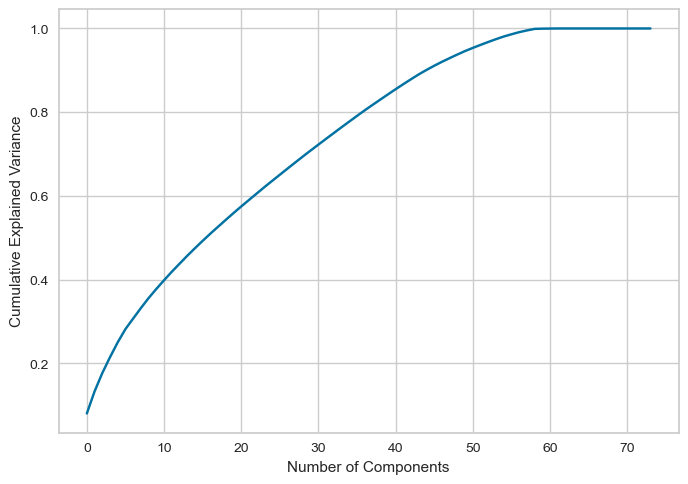

In [25]:
pca = PCA().fit(df_transformed)  
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

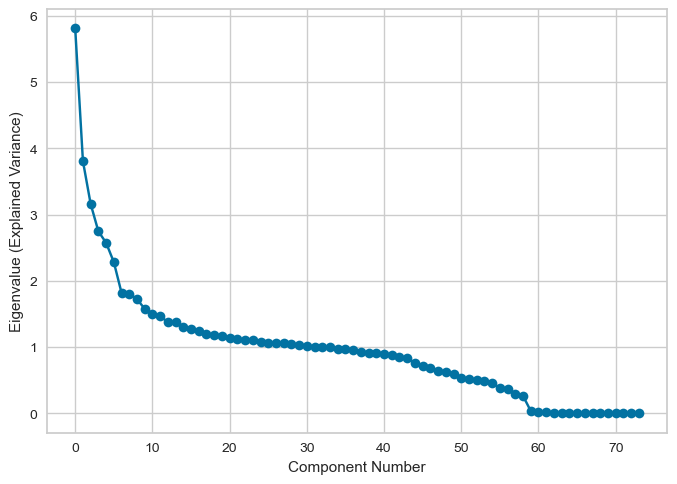

In [26]:
# Scale plot for choosing the best n_components
plt.plot(pca.explained_variance_, 'o-')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.show()

In [27]:
# the best n_components I choose is 6
pca = PCA(n_components=6) 
pca_features = pca.fit_transform(df_transformed)

In [28]:
# calculate the within cluster sum of squares for k from 1 to 9
wcss = {'wcss_score':[], 'no_of_clusters':[]}
for i in range(1,10):
    kmeans = KMeans(i, random_state=0)
    kmeans.fit(pca_features)
    wcss['wcss_score'].append(kmeans.inertia_)
    wcss['no_of_clusters'].append(i)
wcss_df = pd.DataFrame(wcss)

In [29]:
wcss_df

wcss_score  no_of_clusters
0  123877.863762               1
1   99392.300894               2
2   87935.518808               3
3   71602.613754               4
4   64530.053922               5
5   59398.761460               6
6   55377.323002               7
7   51836.961416               8
8   49576.017039               9

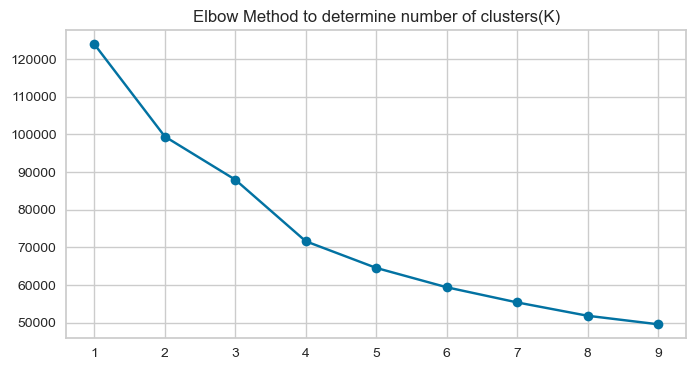

In [30]:
# elbow method
plt.figure(figsize=(8,4))
plt.plot(wcss_df.no_of_clusters, wcss_df.wcss_score, marker='o')
plt.title("Elbow Method to determine number of clusters(K)")
plt.show()

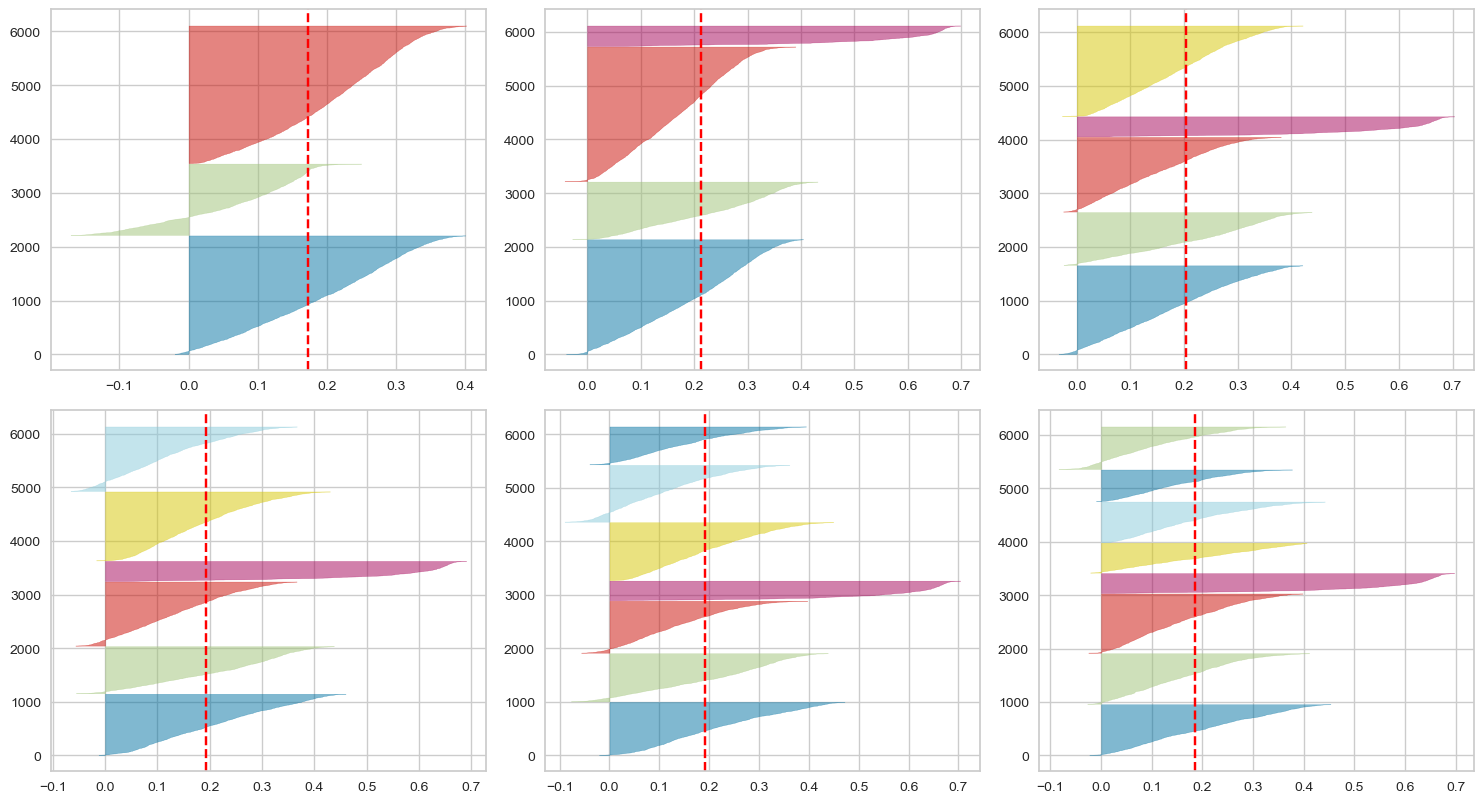

In [31]:
# Silhouette method
n_plots = 10
n_cols = 3  
n_rows = (n_plots + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  
for i, k in enumerate(range(3, 9)):  
    model = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[i])
    visualizer.fit(pca_features)

for j in range(i + 1, n_cols * n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()  

The best k I choose is 4 according to the plots above.

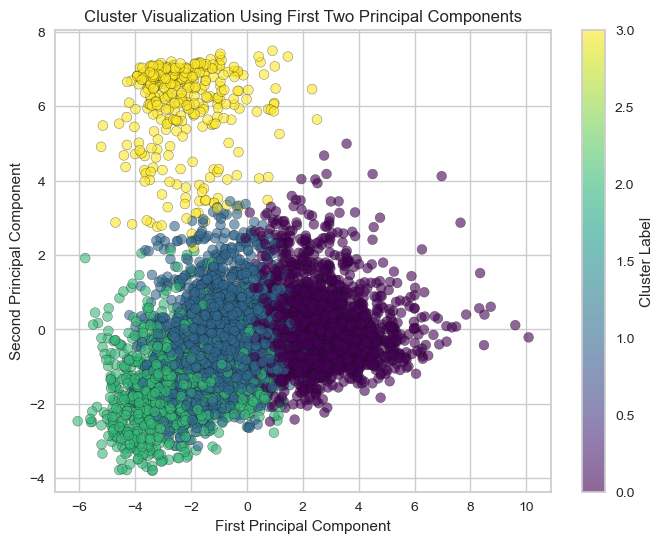

In [32]:
pca = PCA(n_components=6,random_state=42)
data_pca = pca.fit_transform(df_transformed)

# Conduct K-means with the best k found, which is 4
kmeans = KMeans(n_clusters=4,random_state=42)
clusters = kmeans.fit_predict(data_pca)

# Use the first two principal components for visualization
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Cluster Visualization Using First Two Principal Components')
plt.colorbar(label='Cluster Label')
plt.show()

Assign the cluster to each Duolingo user.

In [33]:
cluster_assignments = kmeans.labels_
original_df['cluster'] = cluster_assignments
original_df

user_id duolingo_start_date  daily_goal  \
0     35d349e172c911e98027dca9049399ef 2015-10-29 01:11:00         NaN   
1     35cf9a5c72c911e9a30bdca9049399ef 2015-10-31 14:03:00        50.0   
2     35cebcfd72c911e9ab23dca9049399ef 2015-11-11 08:06:00         NaN   
3     35cf13f372c911e98d09dca9049399ef 2015-11-18 11:02:00         NaN   
4     35d58cf072c911e9a374dca9049399ef 2015-11-19 11:43:00         NaN   
...                                ...                 ...         ...   
6074  35d4f26672c911e9aca2dca9049399ef 2022-05-25 01:49:00         NaN   
6075  35cb1e4f72c911e9b2e9dca9049399ef 2022-05-25 01:57:00         NaN   
6076  35d47eb372c911e9bbdbdca9049399ef 2022-05-25 02:11:00         NaN   
6077  35d1dfd772c911e9b623dca9049399ef 2022-05-25 02:21:00         NaN   
6078  35cb3e4572c911e992a2dca9049399ef 2022-05-25 02:56:00        20.0   

      highest_course_progress took_placement_test  purchased_subscription  \
0                        36.0                True                    True   
1                        64.0               False                    True   
2                        27.0               False                    True   
3                        31.0                True                    True   
4                        54.0               False                   False   
...                       ...                 ...                     ...   
6074                      2.0               False                   False   
6075                     21.0                True                   False   
6076                     23.0               False                   False   
6077                      4.0               False                   False   
6078                      3.0               False                    True   

      highest_crown_count  n_active_days  n_lessons_started  \
0                   130.0             20               50.0   
1                   210.0             89              296.0   
2                   101.0             94               99.0   
3                    80.0             37              138.0   
4                   134.0            248              400.0   
...                   ...            ...                ...   
6074                  3.0              2               22.0   
6075                 38.0              3               25.0   
6076                 38.0              3               32.0   
6077                 13.0              3               59.0   
6078                  6.0              3               31.0   

      n_lessons_completed  ...  \
0                    42.0  ...   
1                   292.0  ...   
2                    93.0  ...   
3                   133.0  ...   
4                   329.0  ...   
...                   ...  ...   
6074                 21.0  ...   
6075                 25.0  ...   
6076                 30.0  ...   
6077                 55.0  ...   
6078                 31.0  ...   

                                        other_resources  \
0     Other apps,Online language class,Other (please...   
1                                                   NaN   
2     Other apps,Textbooks,Stories/novels/children's...   
3     Textbooks,Online language class,Other (please ...   
4     Speak with others (language events, conversati...   
...                                                 ...   
6074  Speak with others (language events, conversati...   
6075                           In-person language class   
6076                 Textbooks,In-person language class   
6077    Stories/novels/children's books,Movies/TV Shows   
6078                                                NaN   

                            primary_language_commitment  \
0         I'm very committed to learning this language.   
1     I'm extremely committed to learning this langu...   
2         I'm very committed to learning this language.   
3         I'm very committed to learning this language.   
4     I'm extremely committed to learning this 

## Analyze the users within each assigned clusters

What's heppned in each cluster??? Please see the detailed analysis in the report :D

In [34]:
original_df['purchased_subscription'] = original_df['purchased_subscription'].astype('object')
original_df['survey_complete'] = original_df['survey_complete'].astype('object')

In [35]:
cluster_means = original_df.groupby('cluster').mean()
cluster_means

daily_goal  highest_course_progress  highest_crown_count  \
cluster                                                             
0         27.652767                37.613115           173.561462   
1         22.362812                22.013232            73.545687   
2         28.221354                21.663516            61.238191   
3         25.835821                20.211640            64.875000   

         n_active_days  n_lessons_started  n_lessons_completed  \
cluster                                                          
0            77.637471         444.426160           416.936709   
1            35.721311         139.598753           130.333472   
2            29.355597         131.905882           122.063725   
3            33.534211         169.367123           150.947945   

         longest_streak  n_days_on_platform  time_spent_seconds  
cluster                                                          
0            252.374707          755.514286         2805.496956  
1            112.801279          571.986405         2647.769692  
2             74.966134          504.087488         4549.936971  
3             73.423684          458.176316         7391.568421

In [36]:
def get_mode(series):
    return series.mode()[0] if not series.mode().empty else None

categorical_columns = original_df.select_dtypes(include=['object']).columns
categorical_columns_with_cluster = categorical_columns.union(['cluster'])
cluster_mode = original_df[categorical_columns_with_cluster].groupby('cluster').agg(get_mode)
cluster_mode

age      annual_income country        duolingo_platform  \
cluster                                                                
0        55 - 74  $26,000 - $75,000      JP           iPhone or iPad   
1        35 - 54  $26,000 - $75,000      GB  Android phone or tablet   
2          18-34       $0 - $10,000      JP  Android phone or tablet   
3        35 - 54       $0 - $10,000      DE  Android phone or tablet   

                             duolingo_subscriber duolingo_usage  \
cluster                                                           
0         Yes, I currently pay for Duolingo Plus          Daily   
1        No, I have never paid for Duolingo Plus          Daily   
2        No, I have never paid for Duolingo Plus          Daily   
3        No, I have never paid for Duolingo Plus          Daily   

          employment_status future_contact  gender  other_resources  \
cluster                                                               
0        Employed full-time            Yes    Male  Movies/TV Shows   
1        Employed full-time            Yes  Female  Movies/TV Shows   
2                Unemployed            Yes  Female  Movies/TV Shows   
3        Employed full-time             No  Female  Movies/TV Shows   

                               primary_language_commitment  \
cluster                                                      
0            I'm very committed to learning this language.   
1        I'm moderately committed to learning this lang...   
2        I'm moderately committed to learning this lang...   
3        I'm moderately committed to learning this lang...   

                               primary_language_motivation  \
cluster                                                      
0           I want to connect with my heritage or identity   
1                          I want to keep my brain healthy   
2                  I want to use my time more productively   
3        I need to be able to speak the local language ...   

        primary_language_motivation_followup primary_language_proficiency  \
cluster                                                                     
0                     Other (please specify)                 Intermediate   
1                     Other (please specify)                     Beginner   
2                     Other (please specify)                     Beginner   
3                     Other (please specify)                     Beginner   

                                   primary_language_review  \
cluster                                                      
0        I am using Duolingo to learn this language for...   
1        I am using Duolingo to review a language I've ...   
2        I am using Duolingo to learn this language for...   
3        I am using Duolingo to learn this language for...   

         purchased_subscription                  student  survey_complete  \
cluster                                                                     
0                          True  Not currently a student                1   
1                         False  Not currently a student                1   
2                         False        Full-time student                1   
3                         False  Not currently a student                0   

         took_placement_test                           user_id  
cluster                                                         
0                       True  35c9fc6e72c911e99681dca9049399ef  
1                      False  35c9fdde72c911e98630dca9049399ef  
2                      False  35ca00d772c911e992e8dca9049399ef  
3                      False  35cb507572c911e98bdcdca9049399ef

**For cluster 0:**

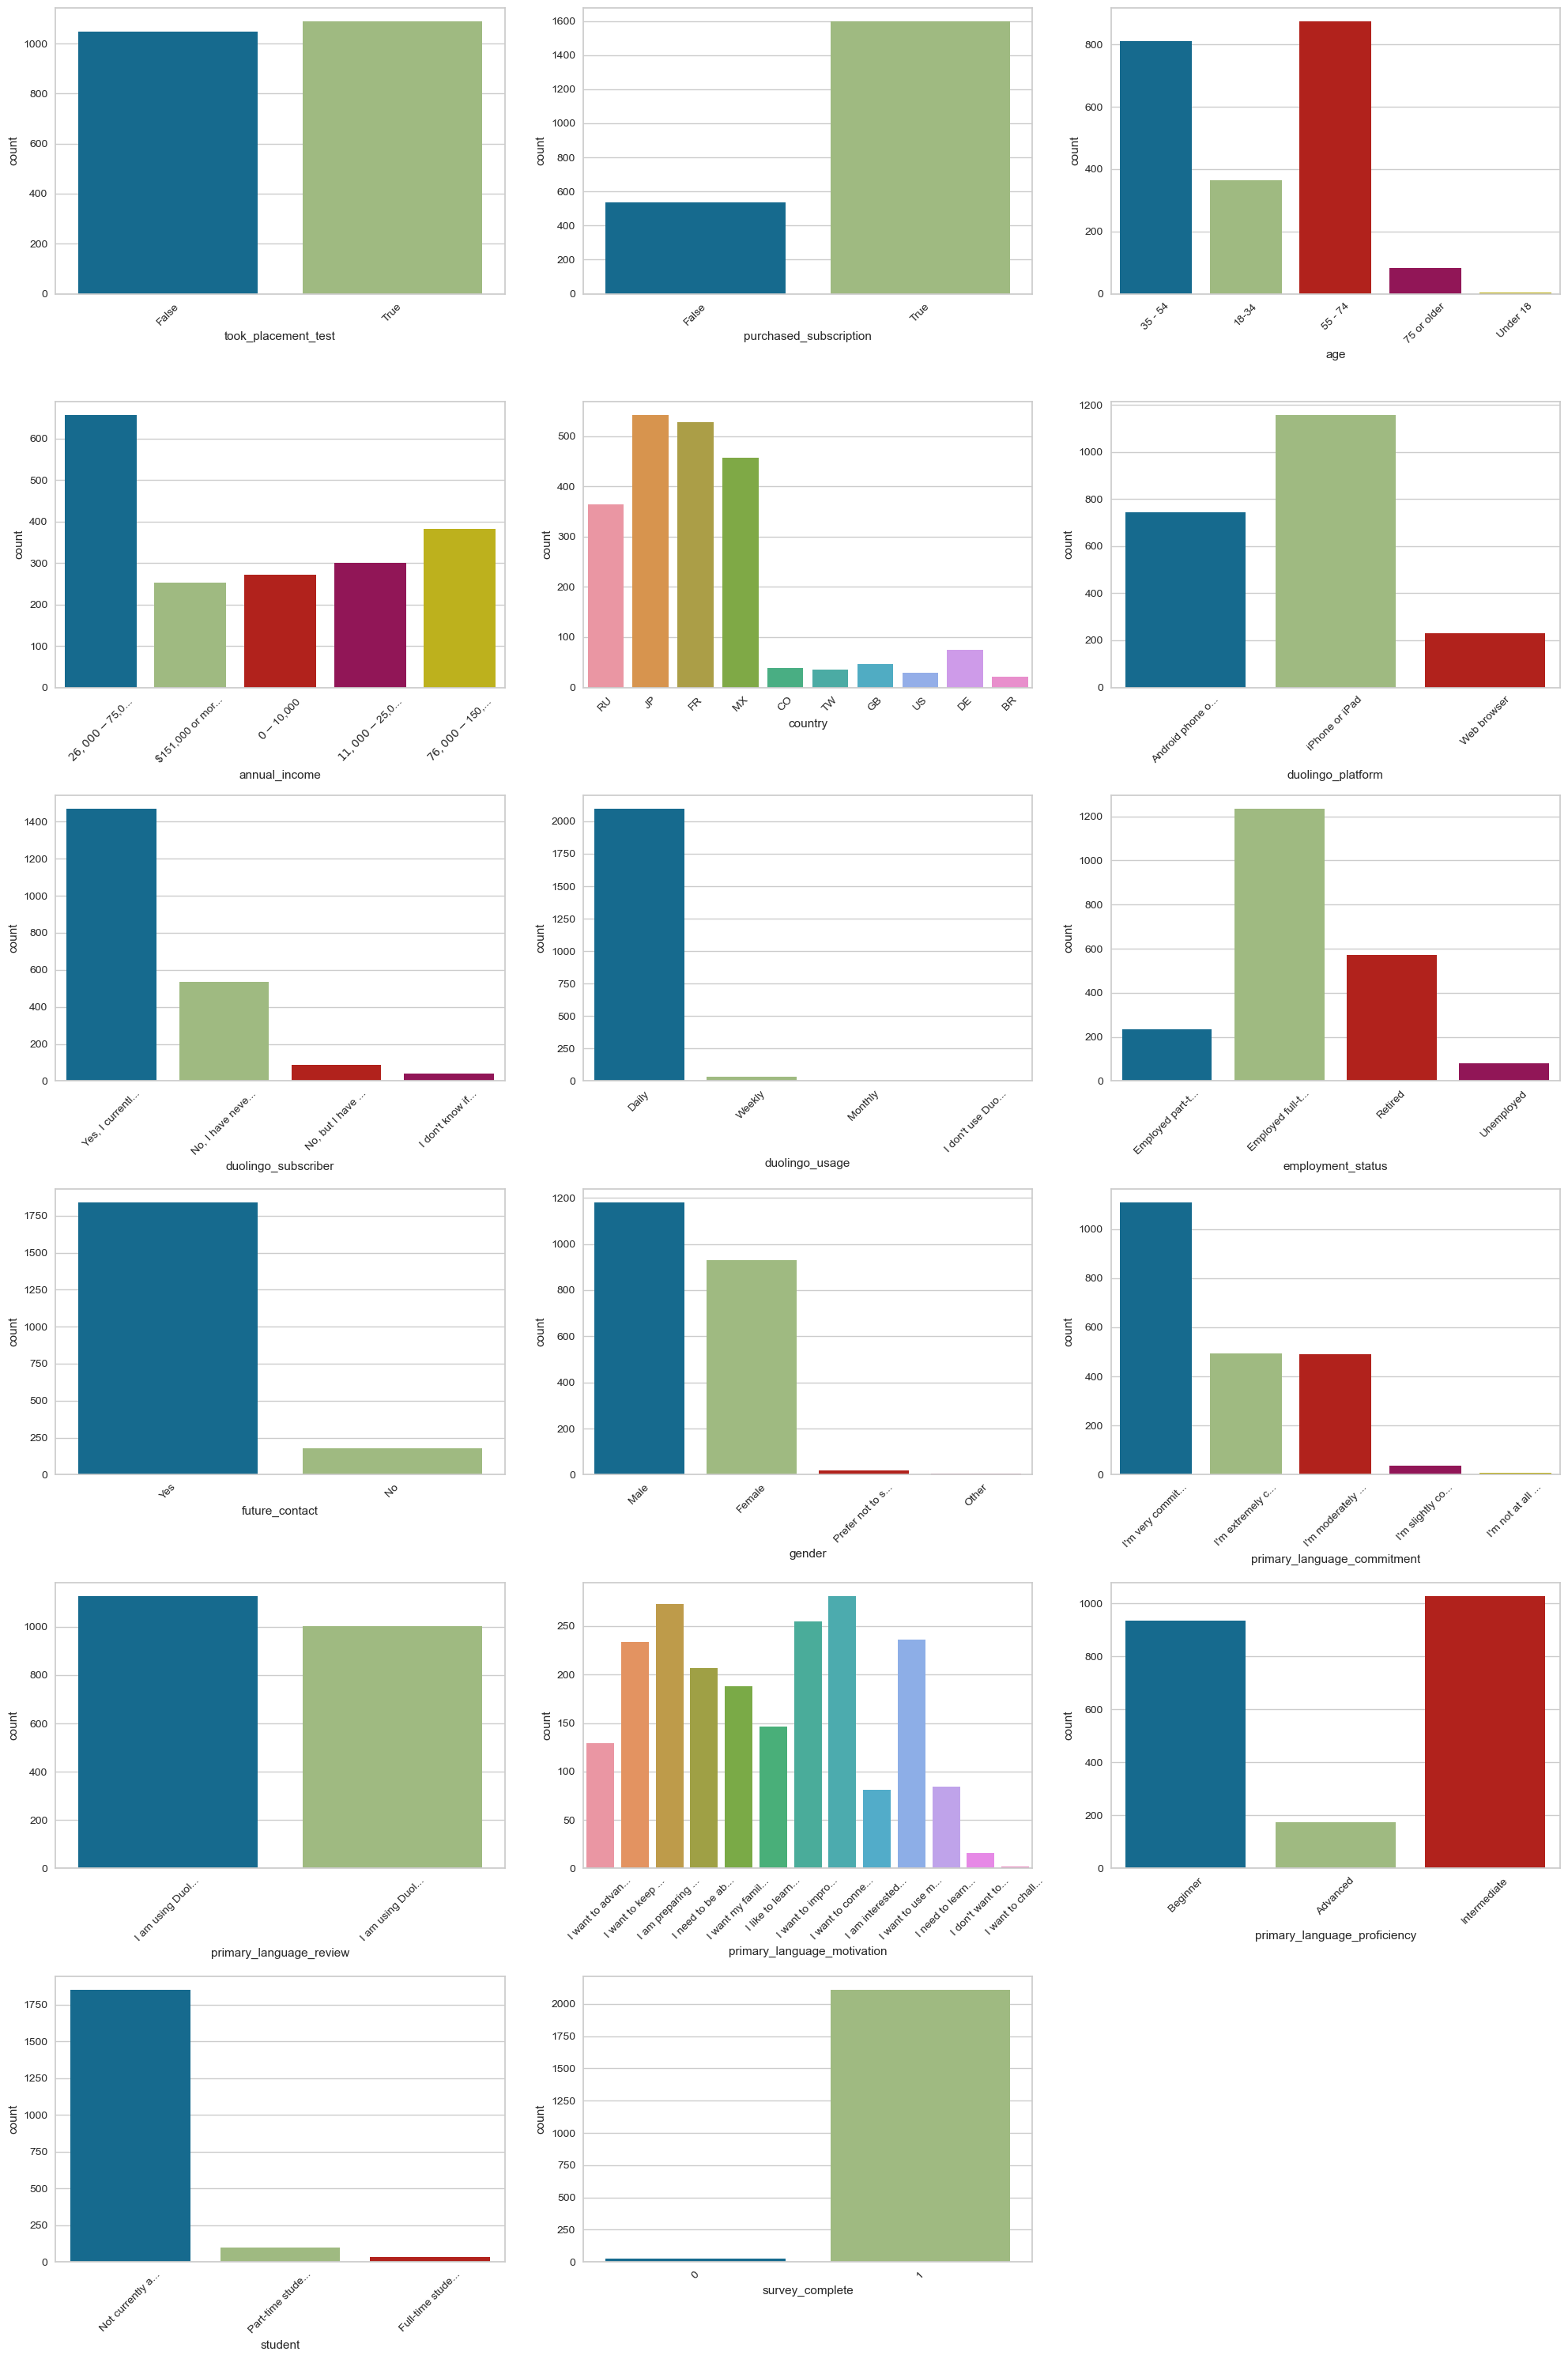

In [37]:
cluster_0 = original_df[original_df['cluster'] == 0]
cluster_0 = cluster_0.drop(['user_id', 'duolingo_start_date', 'other_resources', 'primary_language_motivation_followup'], axis=1)

def truncate_label(text, max_length=15):
    if len(text) > max_length:
        return text[:max_length] + '...'  
    else:
        return text

categorical_columns = cluster_0.select_dtypes(include=['object']).columns

n_cols = 3  
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  
axes = axes.flatten()  

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=cluster_0, ax=axes[i])
    axes[i].set_xticklabels([truncate_label(label.get_text()) for label in axes[i].get_xticklabels()], rotation=45)

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

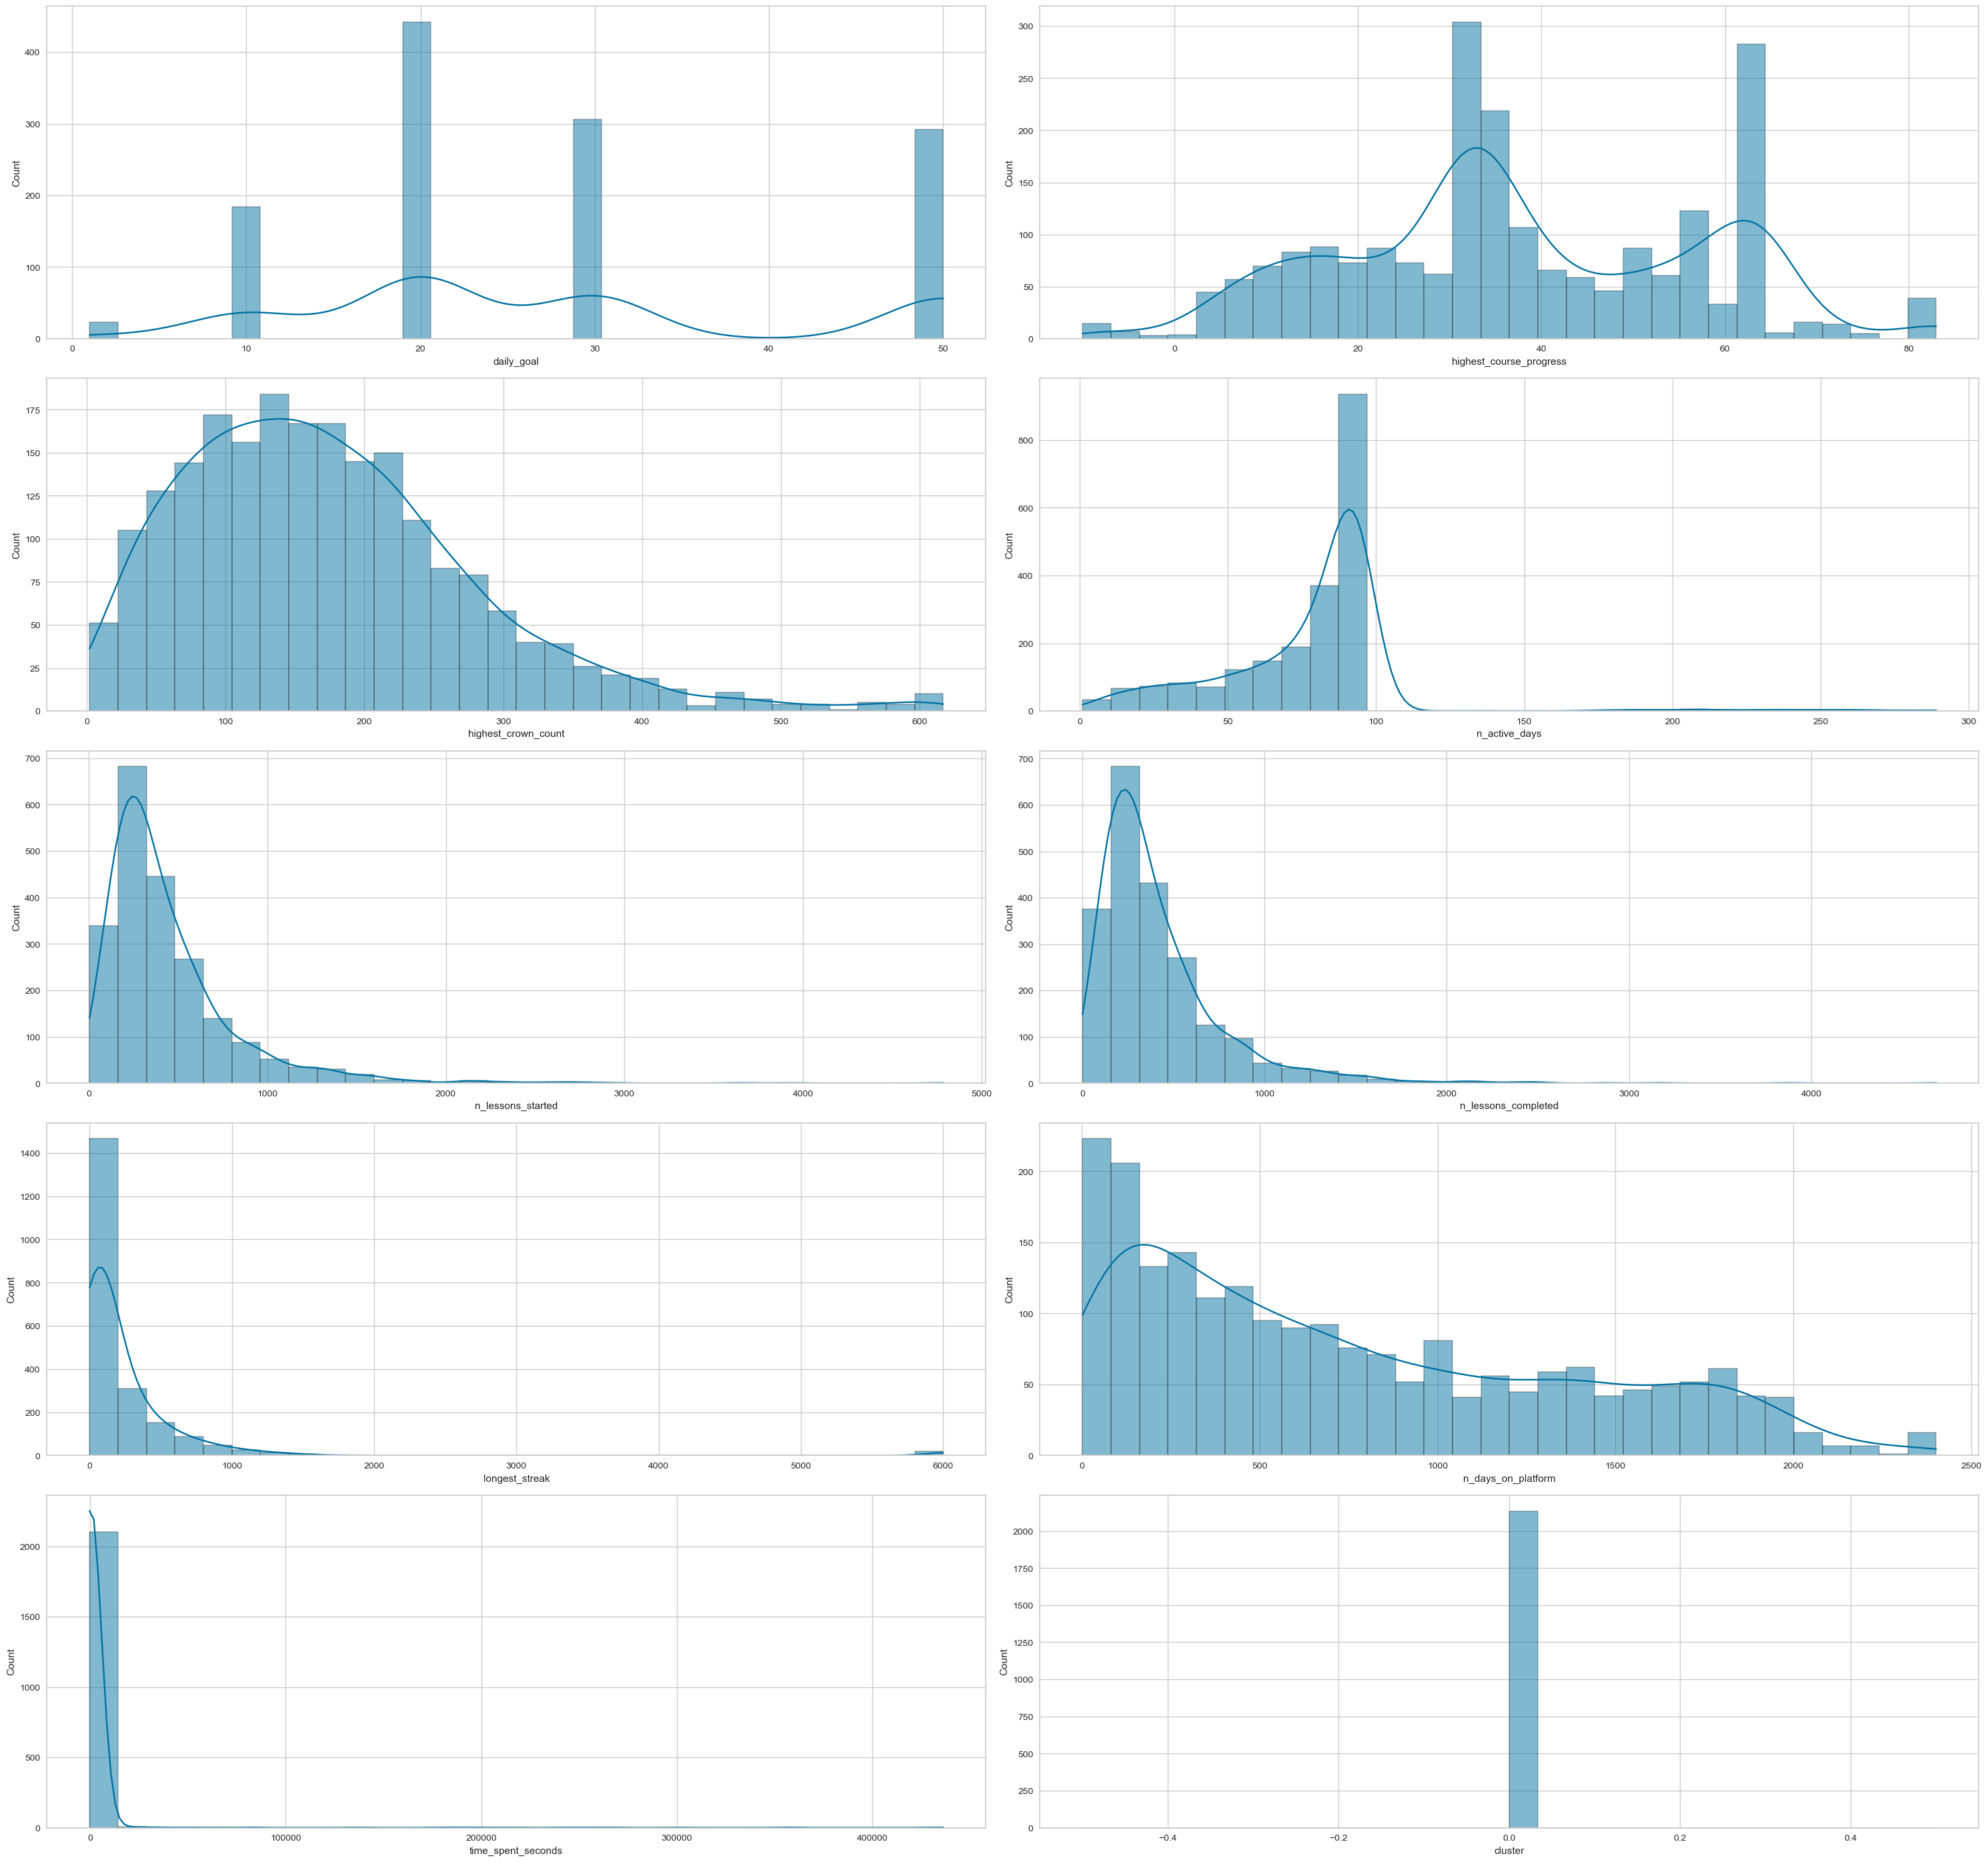

In [38]:
numeric_columns = cluster_0.select_dtypes(include=[np.number]).columns

n_cols = 2 
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 50))  
axes = axes.flatten() 

for i, col in enumerate(numeric_columns):
    sns.histplot(cluster_0[col], bins=30, kde=True, ax=axes[i])
    plt.title(f'Distribution of {col}')

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**For cluster 1:**

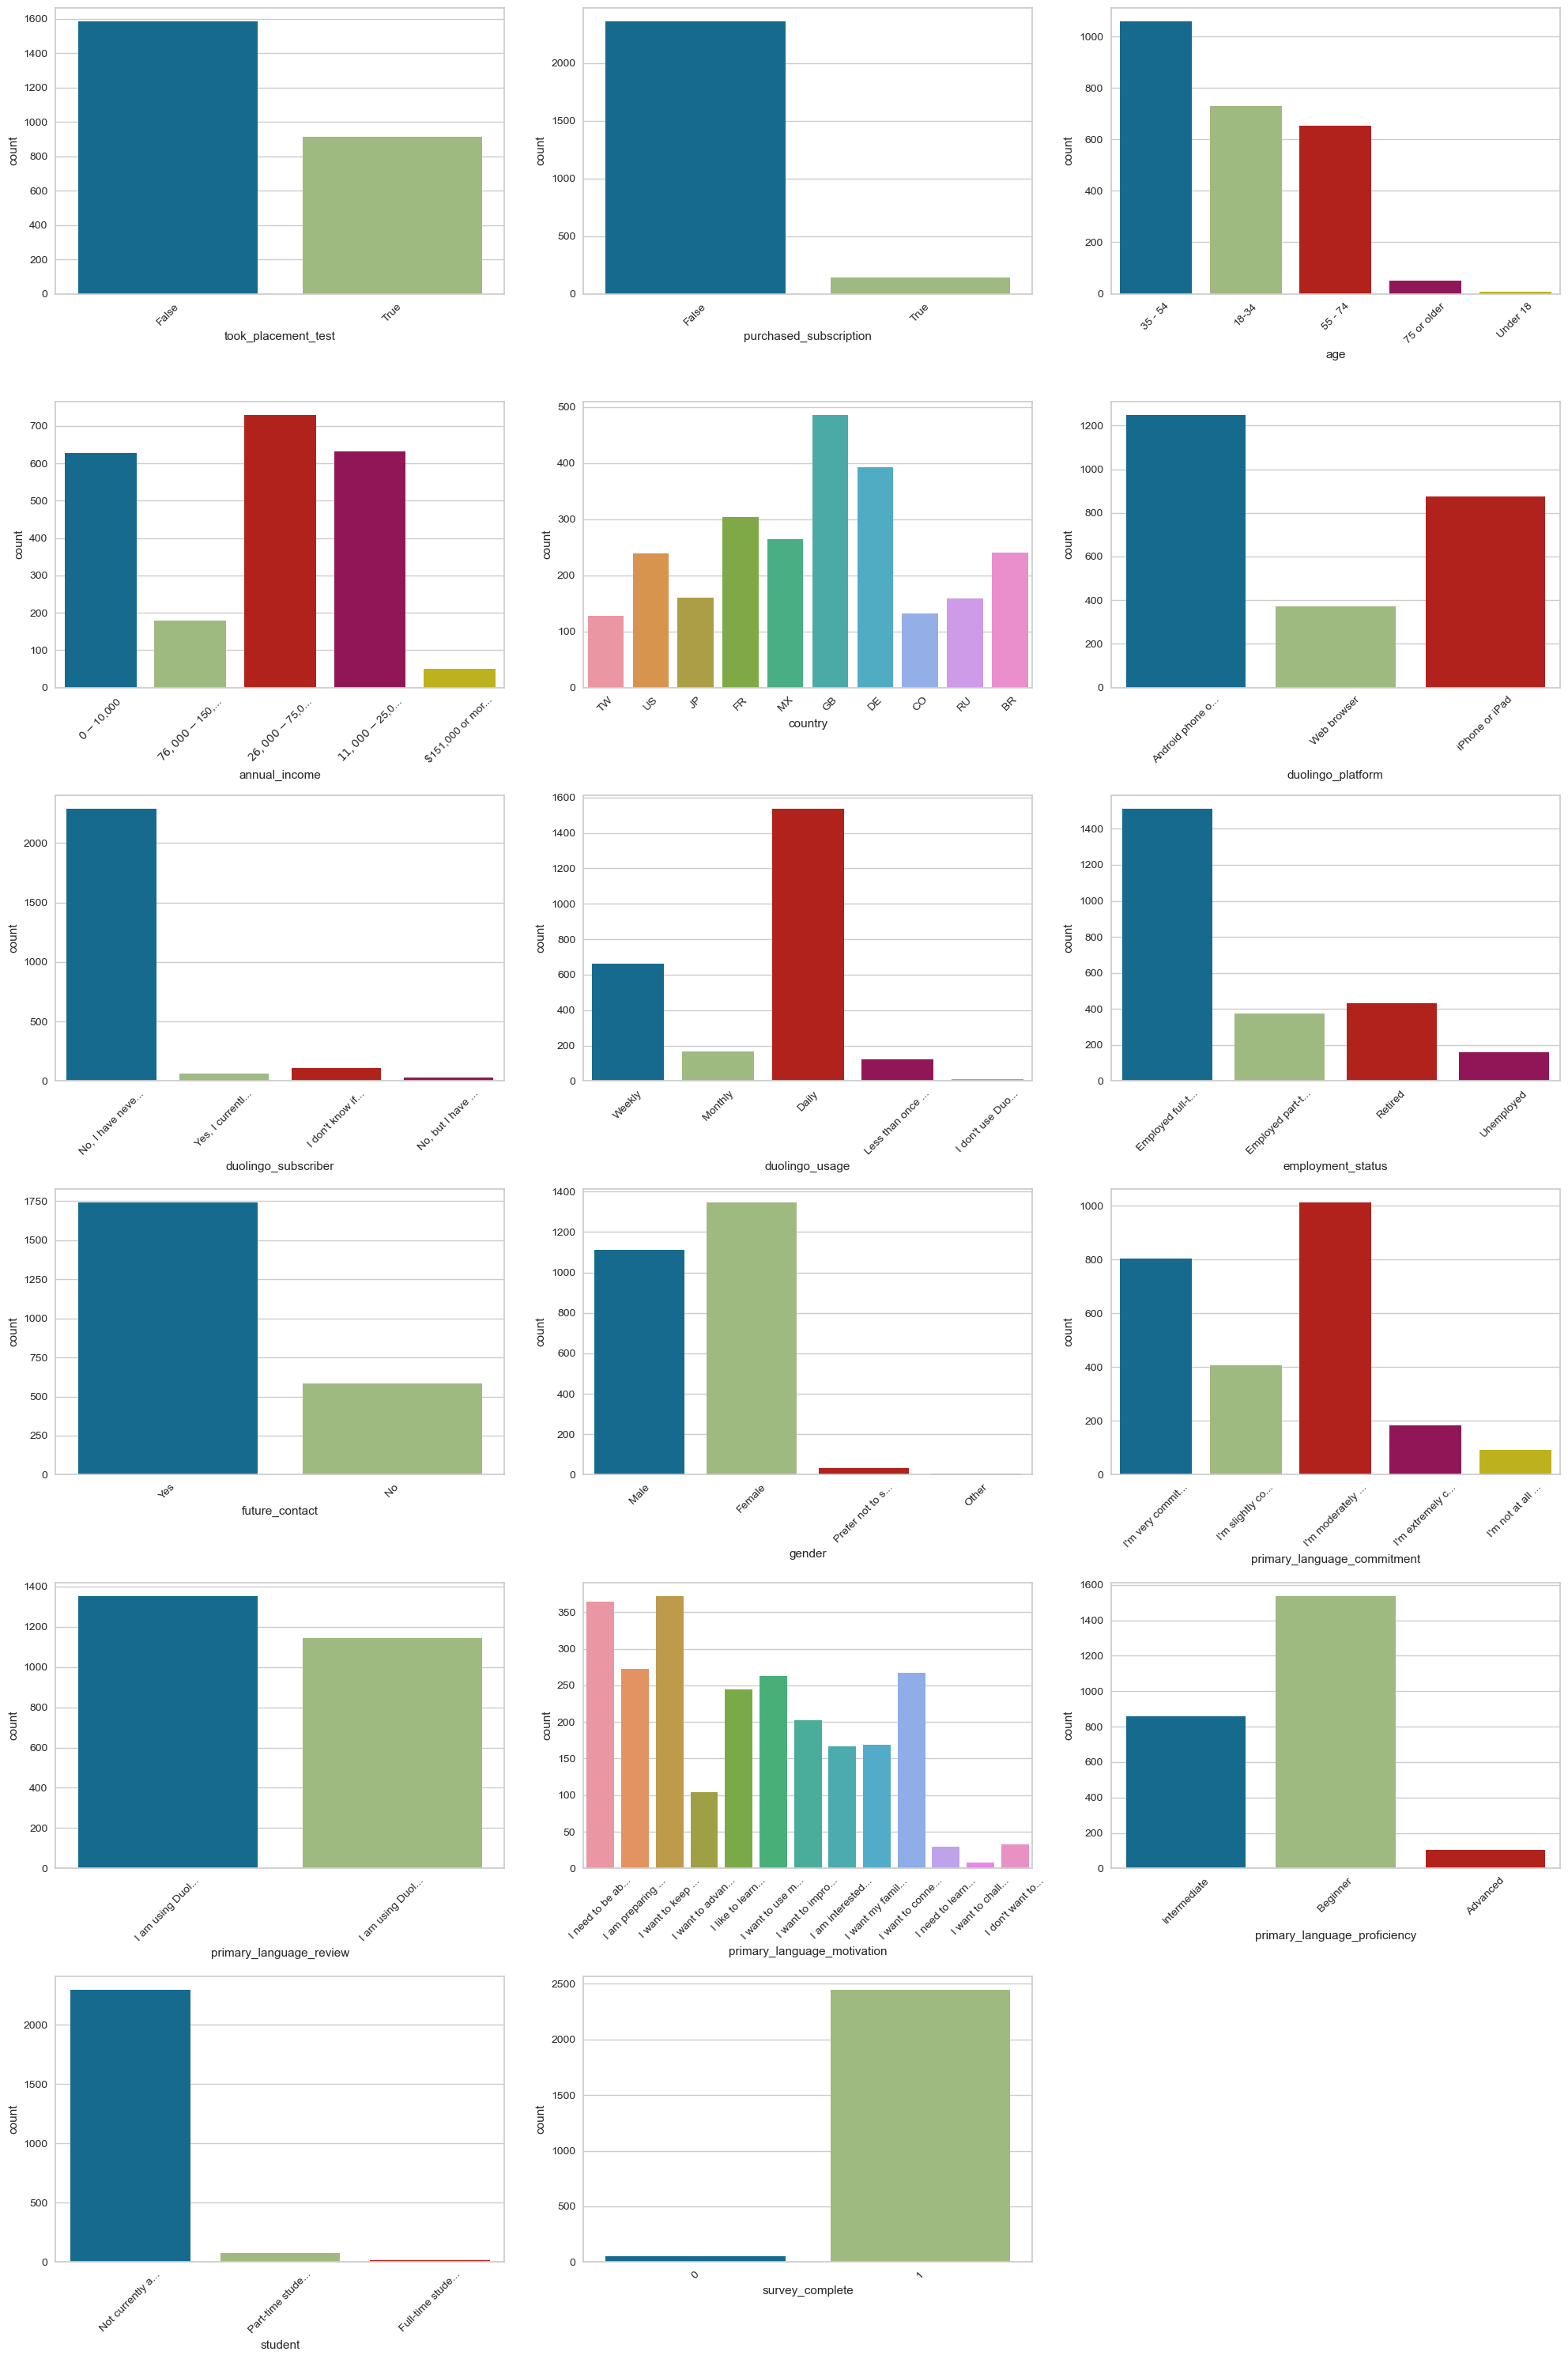

In [39]:
cluster_1 = original_df[original_df['cluster'] == 1]
cluster_1 = cluster_1.drop(['user_id', 'duolingo_start_date', 'other_resources', 'primary_language_motivation_followup'], axis=1)

def truncate_label(text, max_length=15):
    if len(text) > max_length:
        return text[:max_length] + '...'  
    else:
        return text

categorical_columns = cluster_1.select_dtypes(include=['object']).columns

n_cols = 3  
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  
axes = axes.flatten()  

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=cluster_1, ax=axes[i])
    axes[i].set_xticklabels([truncate_label(label.get_text()) for label in axes[i].get_xticklabels()], rotation=45)

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

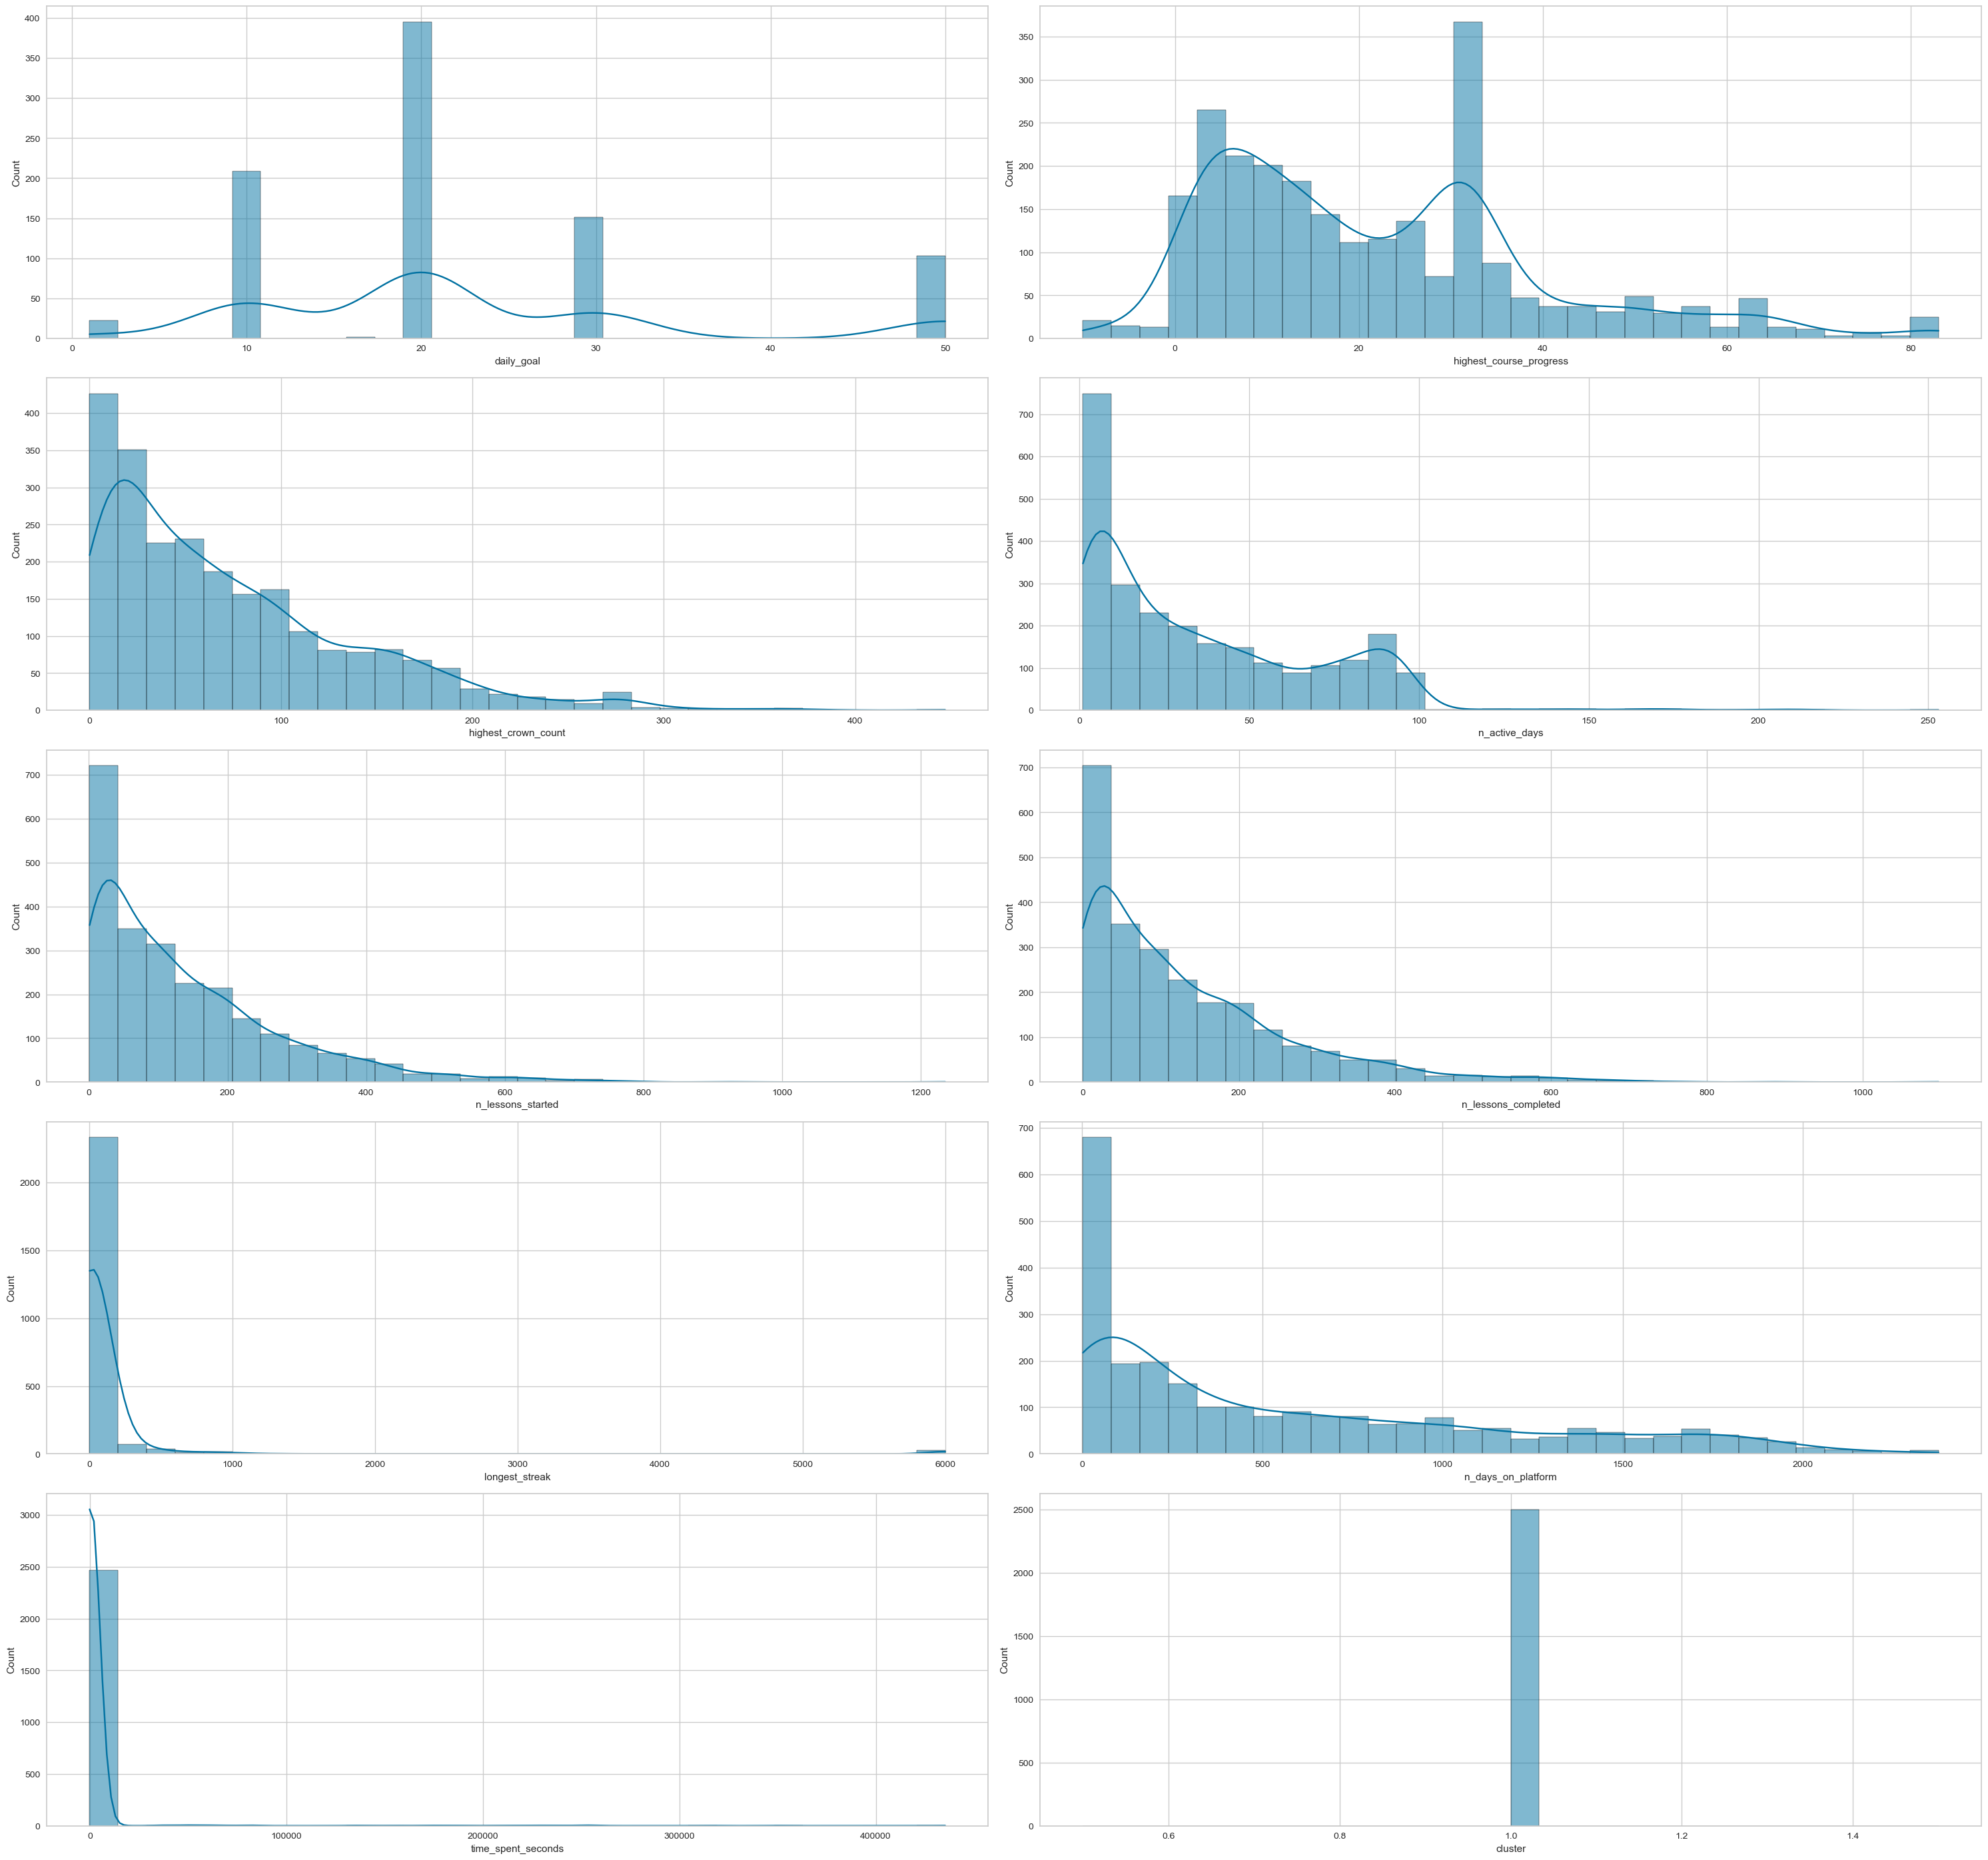

In [40]:
numeric_columns = cluster_1.select_dtypes(include=[np.number]).columns

n_cols = 2 
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 50))  
axes = axes.flatten() 

for i, col in enumerate(numeric_columns):
    sns.histplot(cluster_1[col], bins=30, kde=True, ax=axes[i])
    plt.title(f'Distribution of {col}')

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**For cluster 2:**

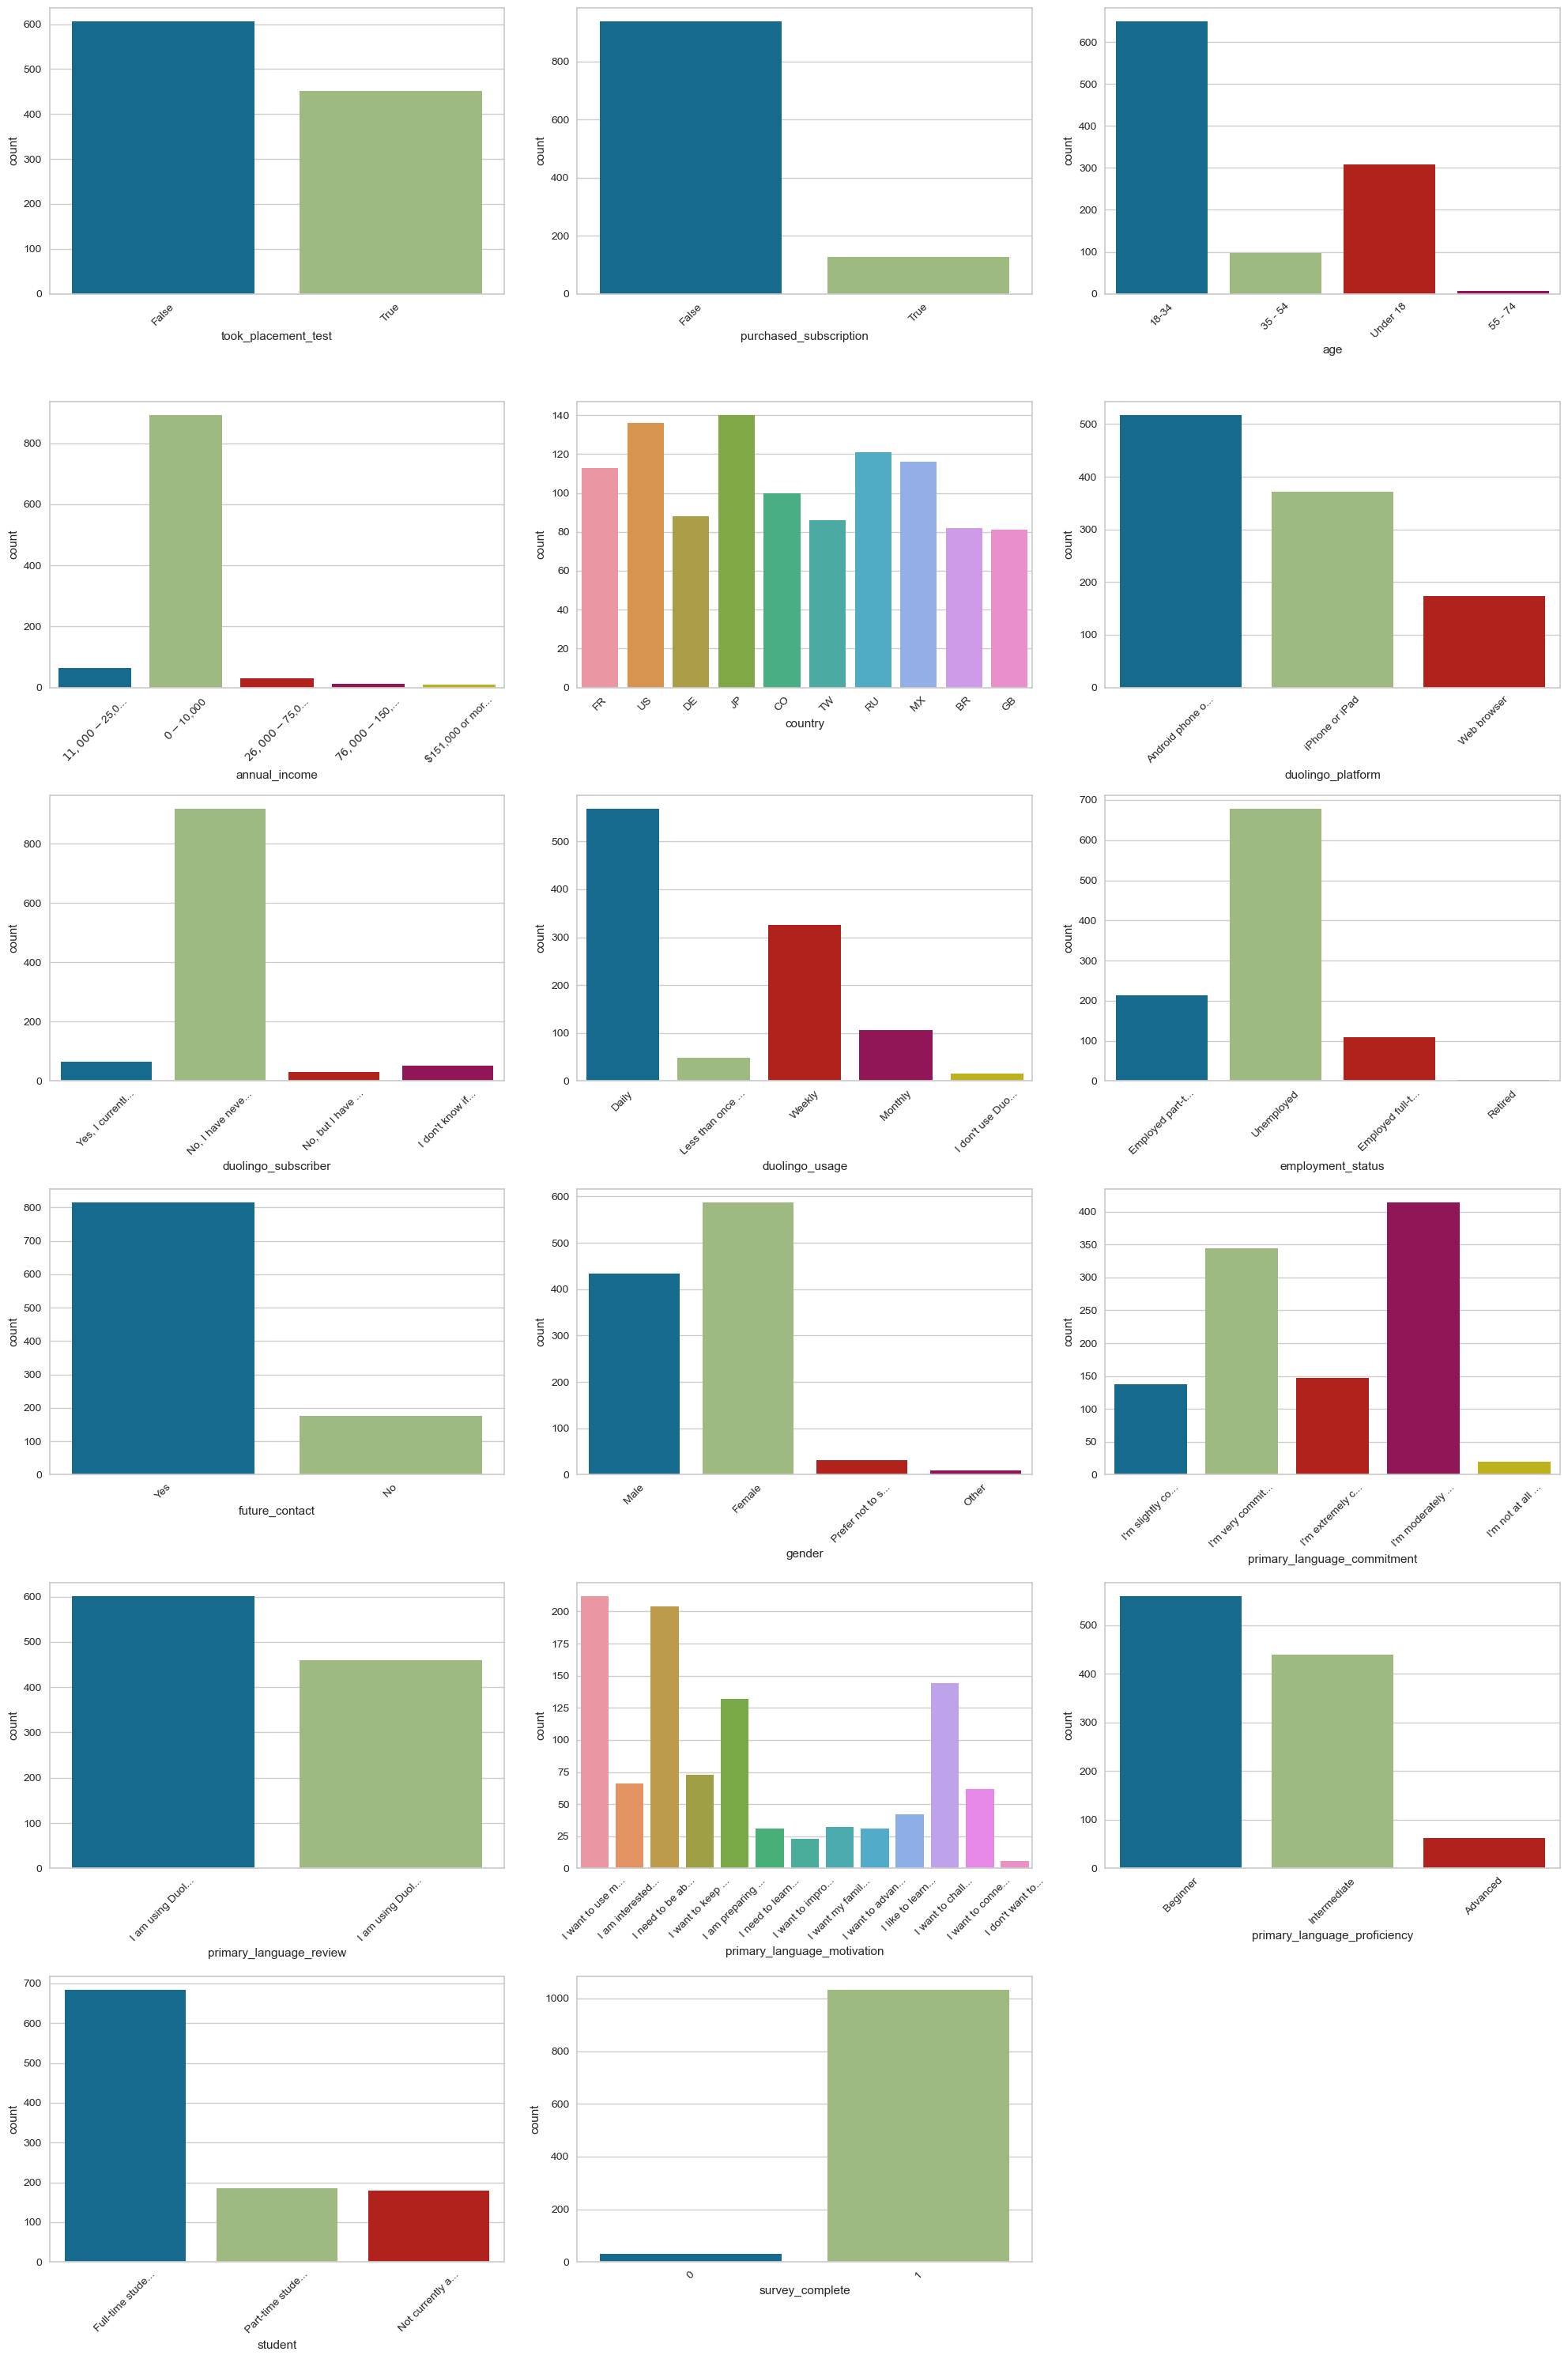

In [41]:
cluster_2 = original_df[original_df['cluster'] == 2]
cluster_2 = cluster_2.drop(['user_id', 'duolingo_start_date', 'other_resources', 'primary_language_motivation_followup'], axis=1)

def truncate_label(text, max_length=15):
    if len(text) > max_length:
        return text[:max_length] + '...'  
    else:
        return text

categorical_columns = cluster_2.select_dtypes(include=['object']).columns

n_cols = 3  
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  
axes = axes.flatten()  

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=cluster_2, ax=axes[i])
    axes[i].set_xticklabels([truncate_label(label.get_text()) for label in axes[i].get_xticklabels()], rotation=45)

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

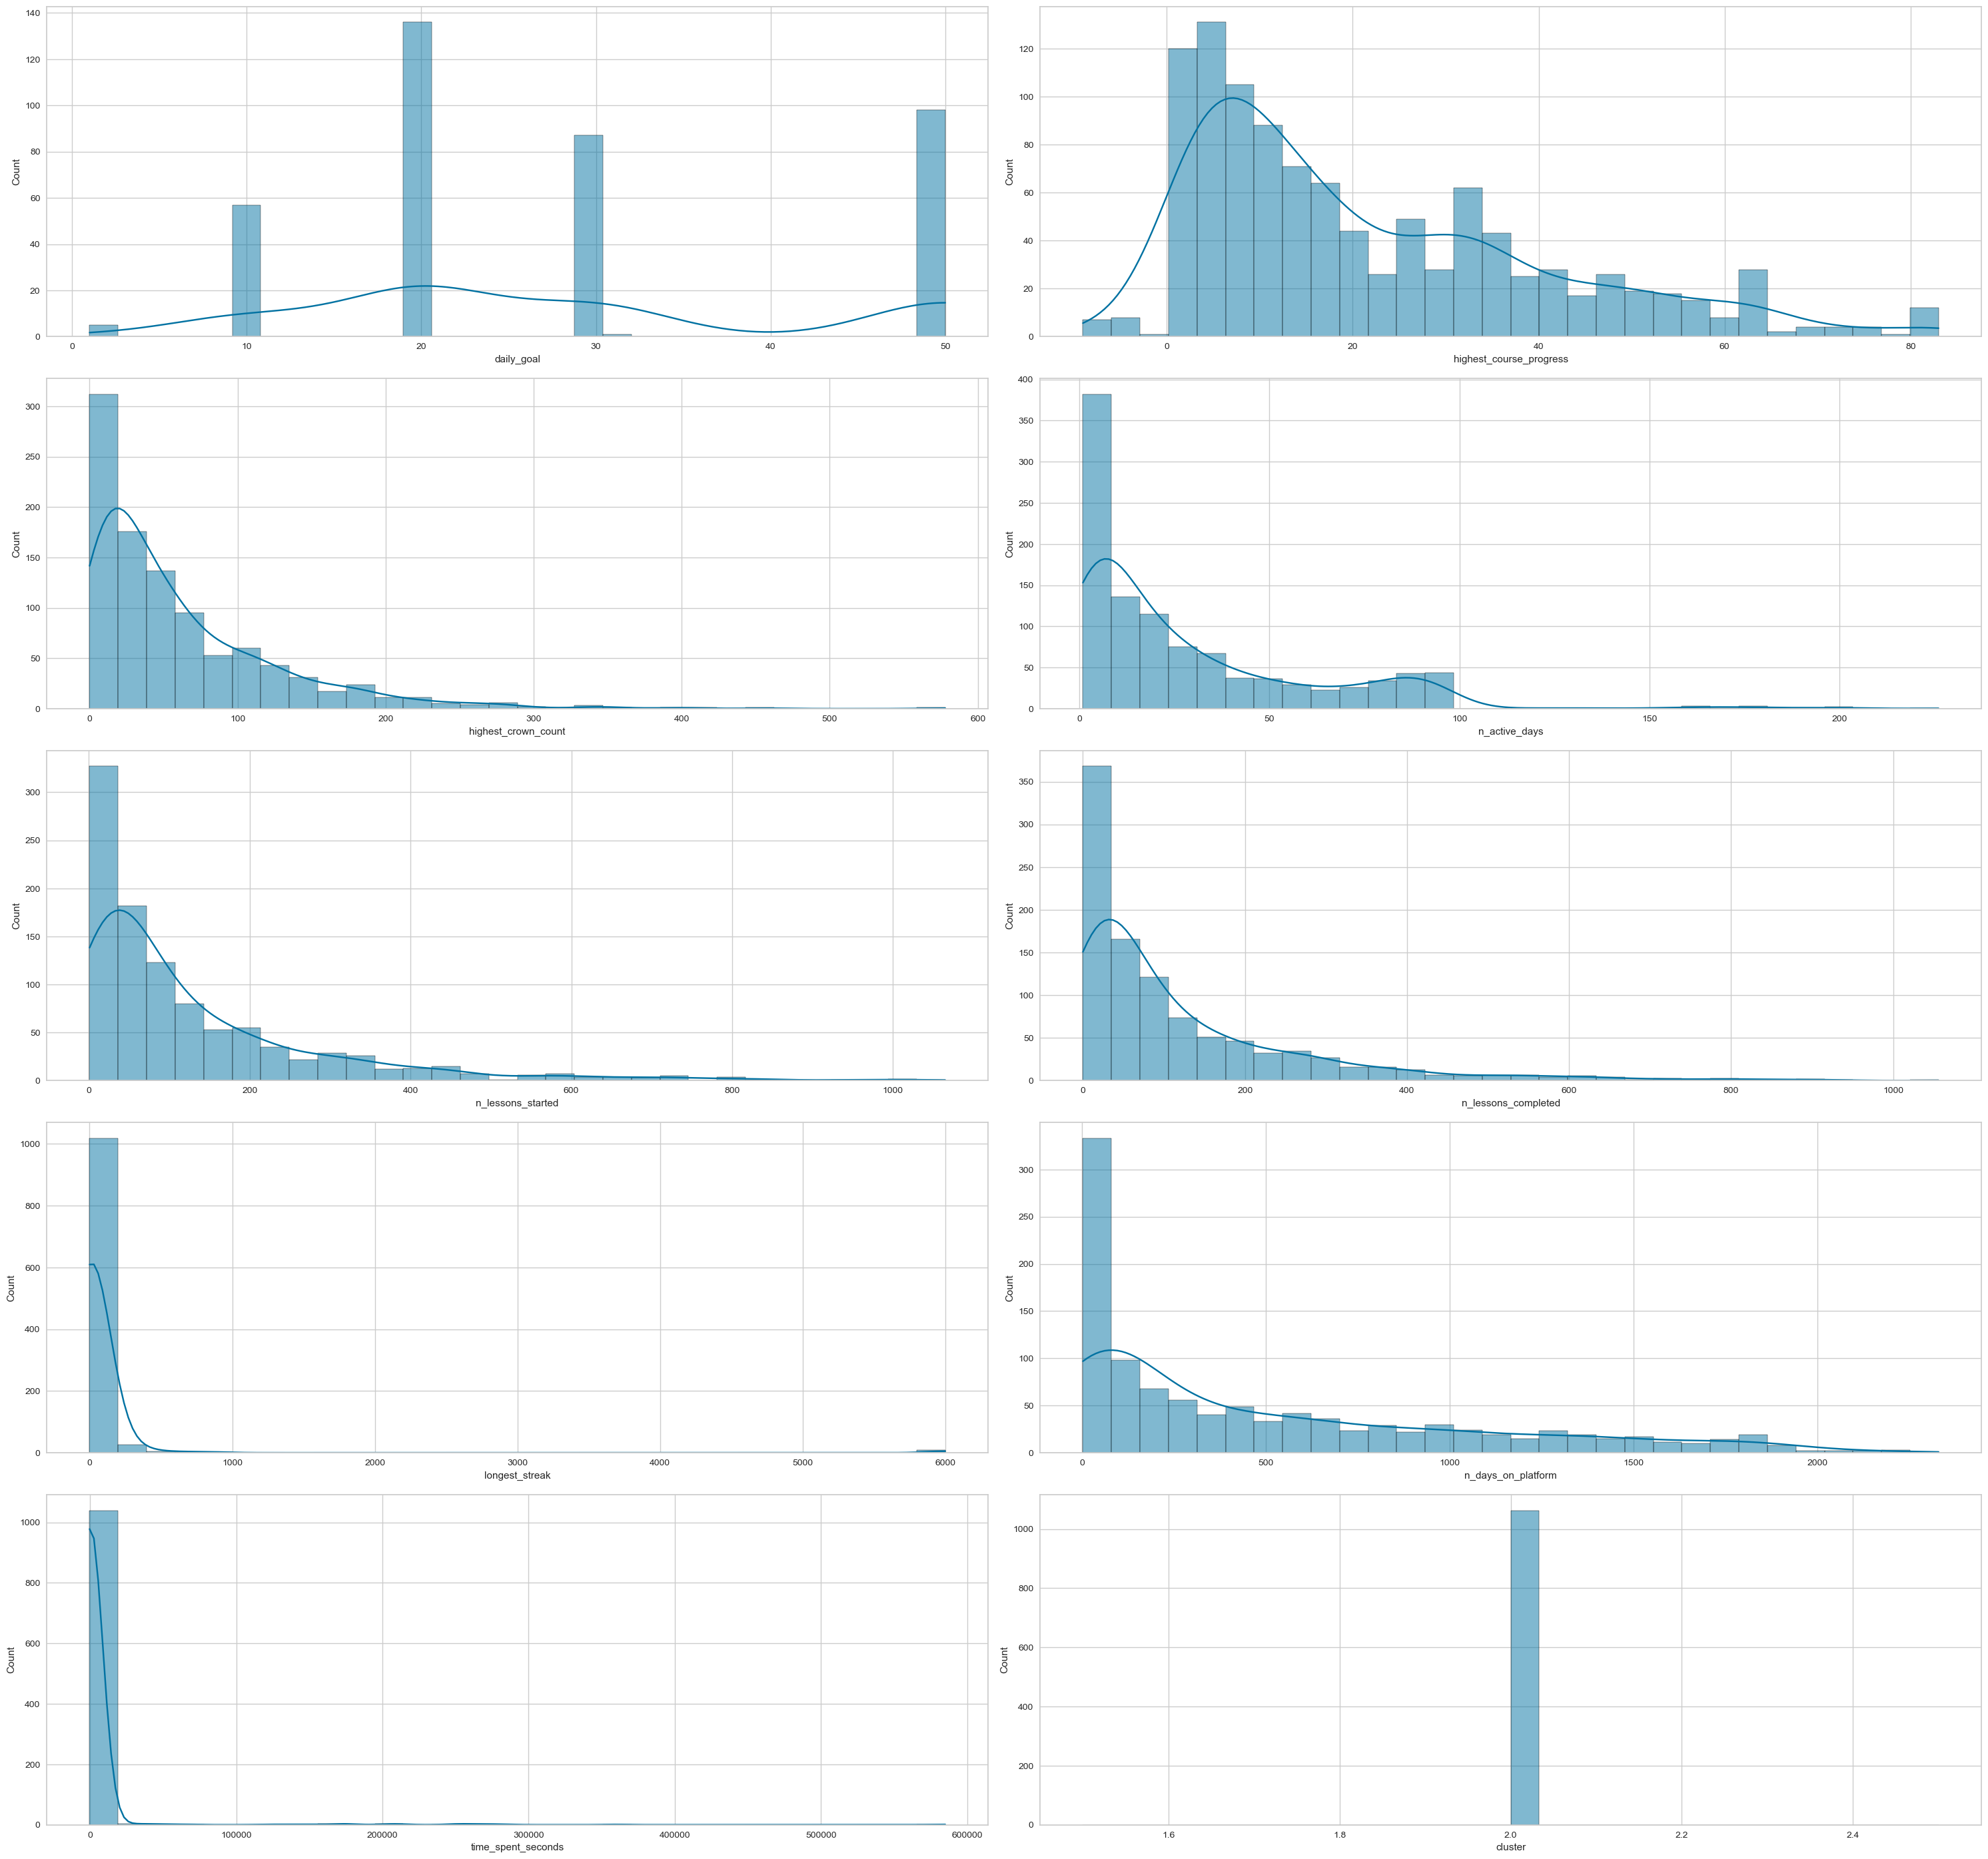

In [42]:
numeric_columns = cluster_2.select_dtypes(include=[np.number]).columns

n_cols = 2 
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 50))  
axes = axes.flatten() 

for i, col in enumerate(numeric_columns):
    sns.histplot(cluster_2[col], bins=30, kde=True, ax=axes[i])
    plt.title(f'Distribution of {col}')

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**For cluster 3:**

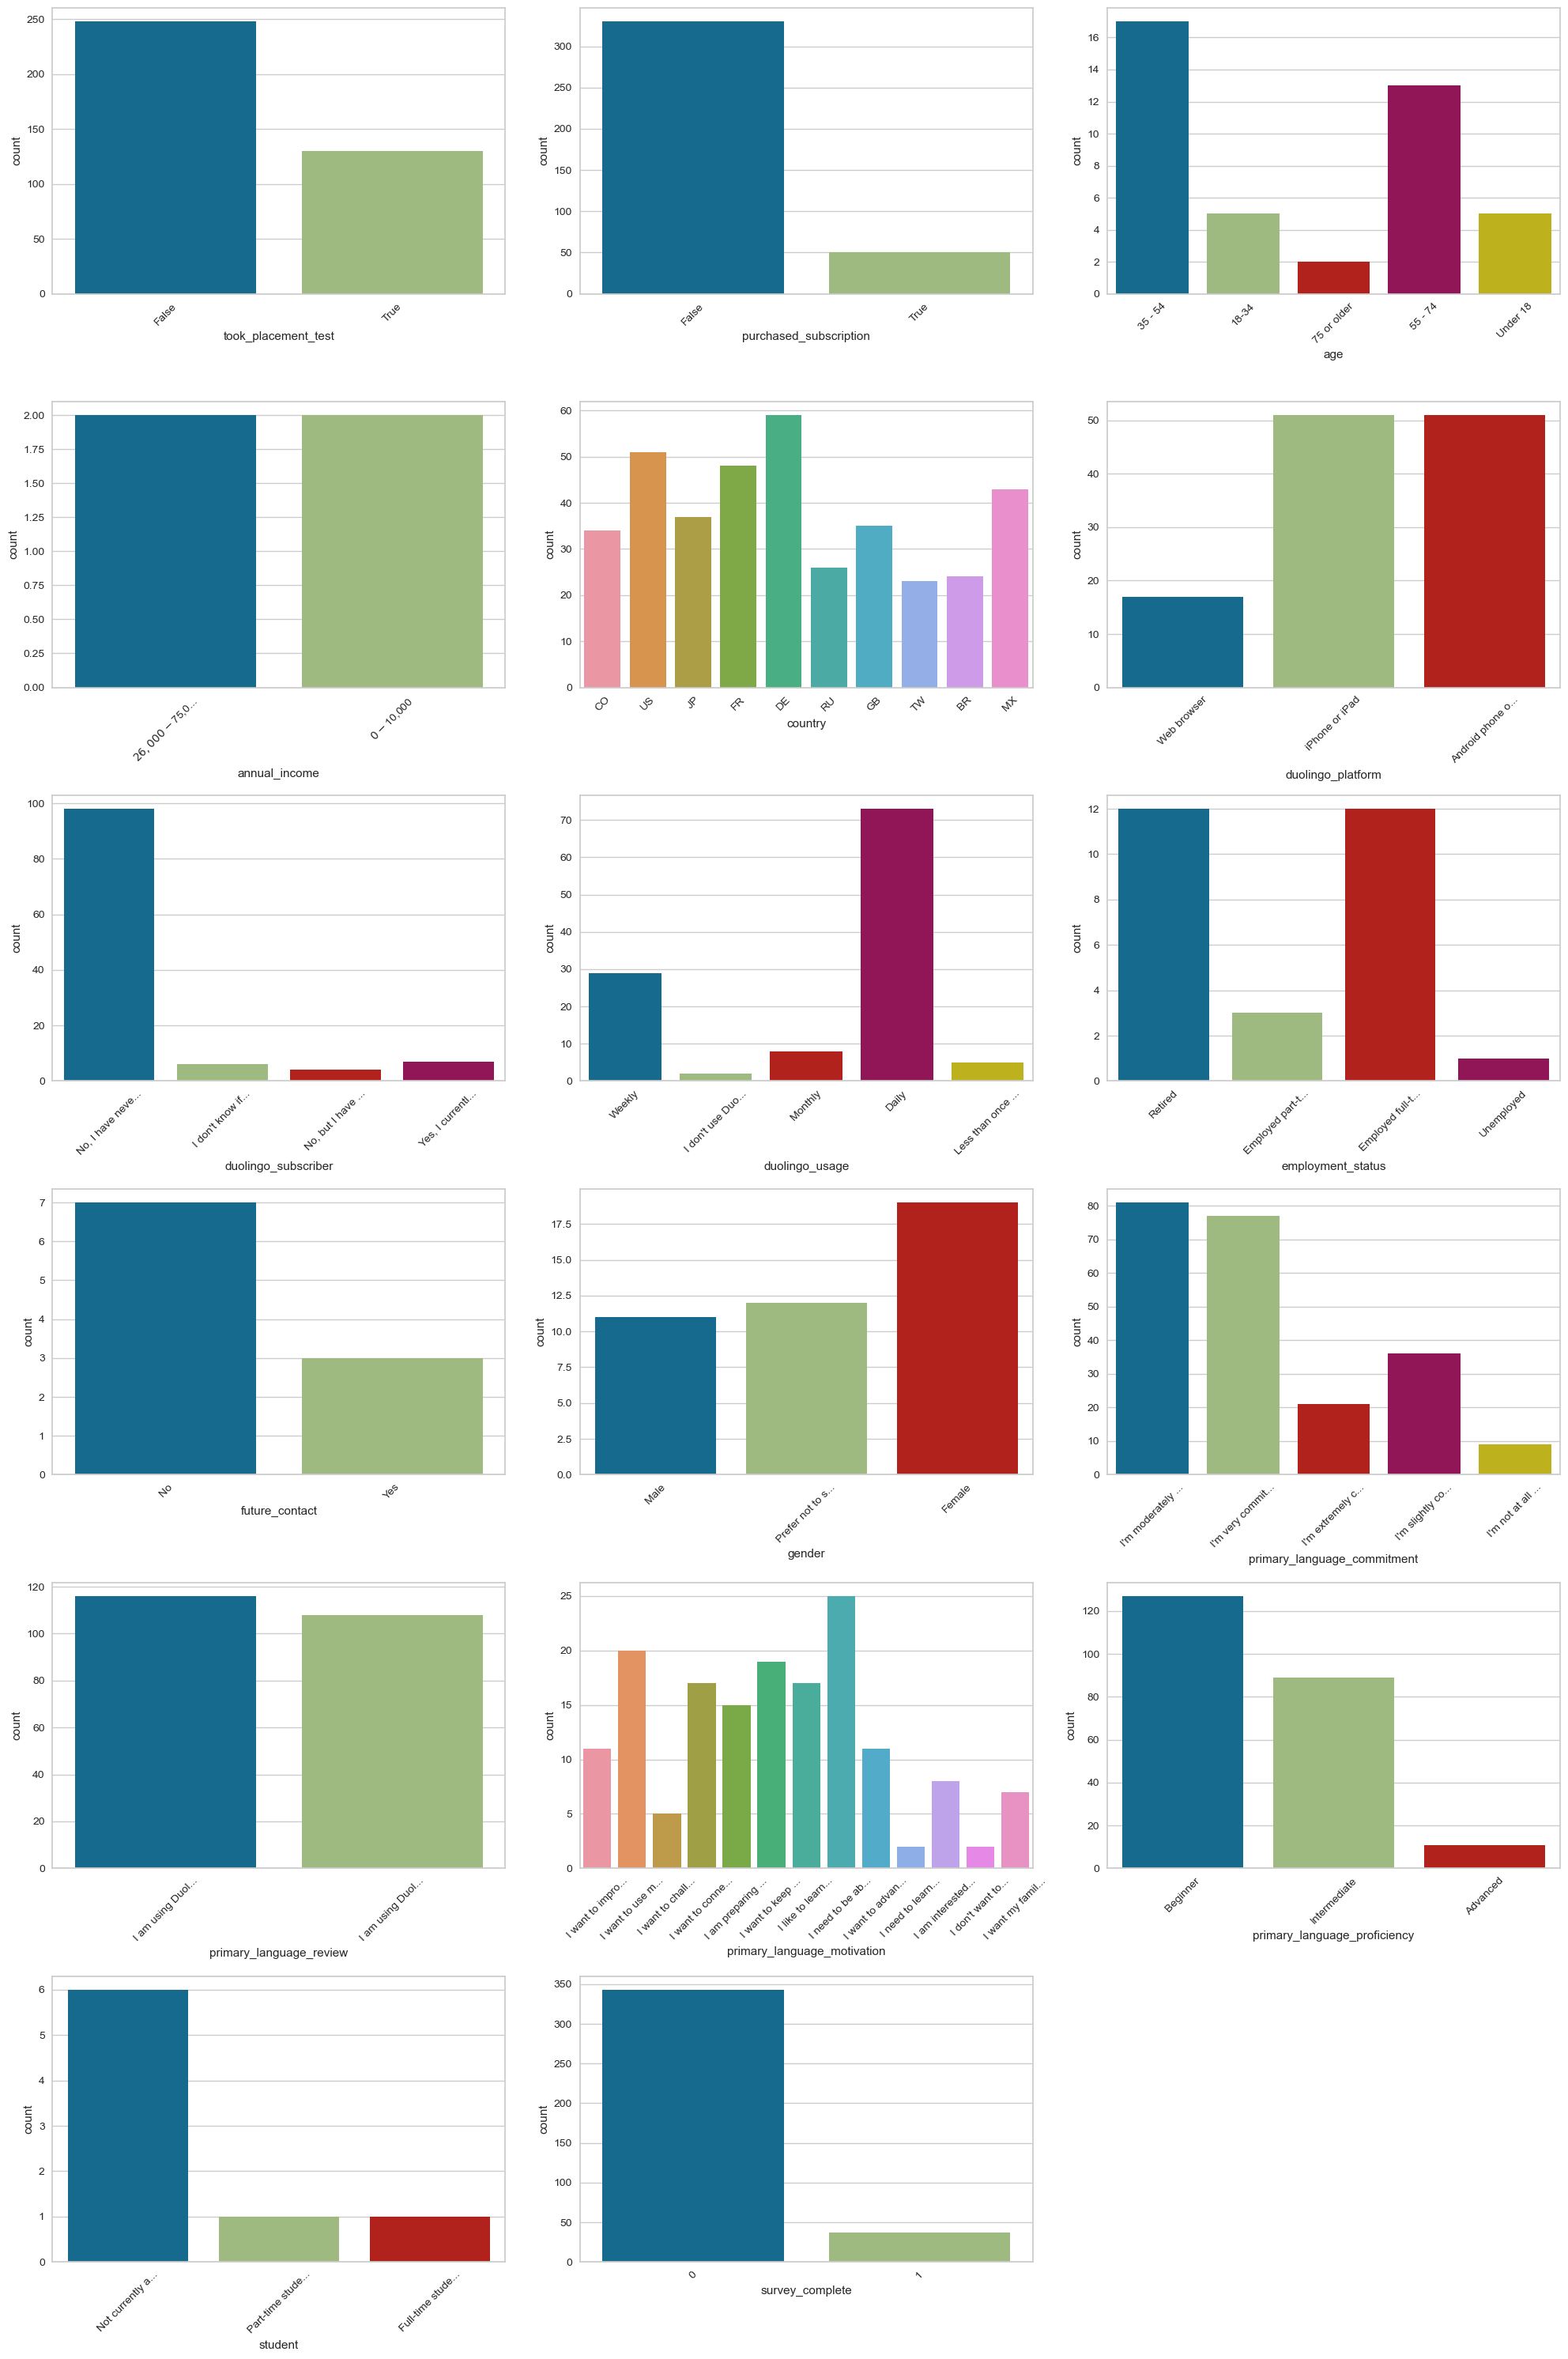

In [43]:
cluster_3 = original_df[original_df['cluster'] == 3]
cluster_3 = cluster_3.drop(['user_id', 'duolingo_start_date', 'other_resources', 'primary_language_motivation_followup'], axis=1)

def truncate_label(text, max_length=15):
    if len(text) > max_length:
        return text[:max_length] + '...'  
    else:
        return text

categorical_columns = cluster_3.select_dtypes(include=['object']).columns

n_cols = 3  
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  
axes = axes.flatten()  

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=cluster_3, ax=axes[i])
    axes[i].set_xticklabels([truncate_label(label.get_text()) for label in axes[i].get_xticklabels()], rotation=45)

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

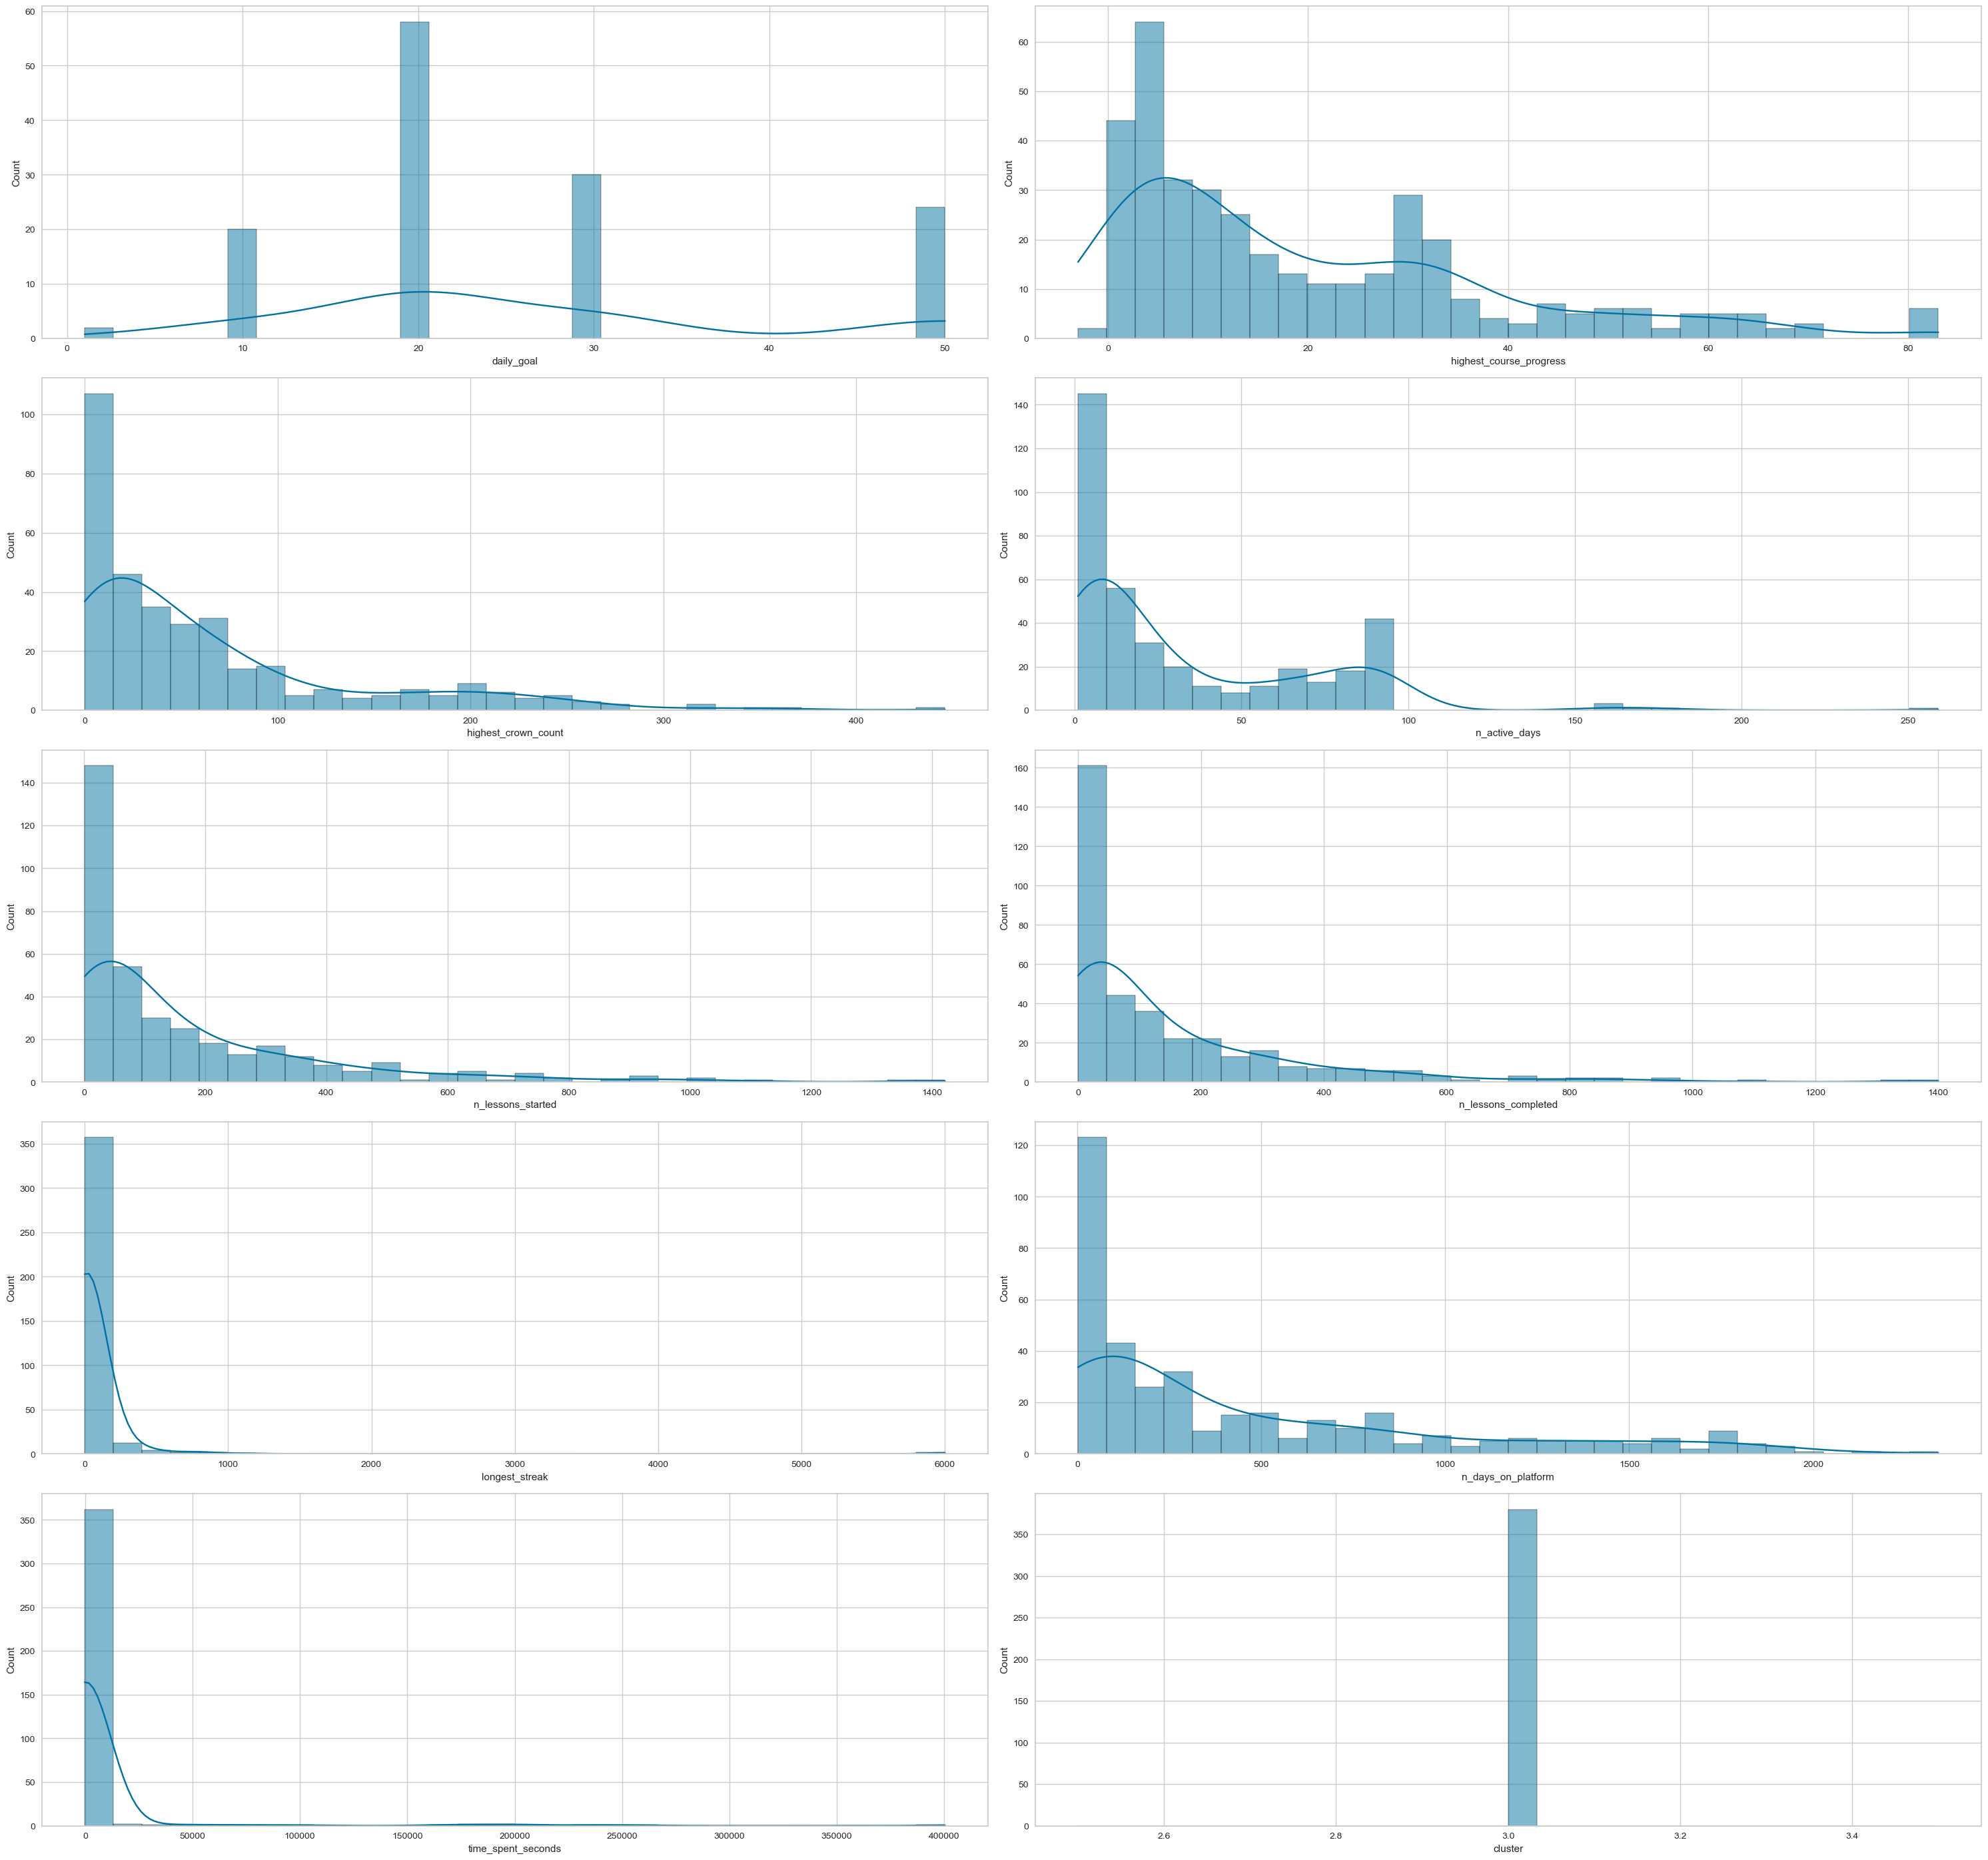

In [44]:
numeric_columns = cluster_3.select_dtypes(include=[np.number]).columns

n_cols = 2 
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 50))  
axes = axes.flatten() 

for i, col in enumerate(numeric_columns):
    sns.histplot(cluster_3[col], bins=30, kde=True, ax=axes[i])
    plt.title(f'Distribution of {col}')

for j in range(i+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Below are the section for calculating the percentage for each cluster

**For cluster 0:**

In [45]:
original_df['primary_language_commitment'].value_counts(normalize=True) * 100

I'm very committed to learning this language.          39.388307
I'm moderately committed to learning this language.    33.727611
I'm extremely committed to learning this language.     14.278472
I'm slightly committed to learning this language.      10.425820
I'm not at all committed to learning this language.     2.179790
Name: primary_language_commitment, dtype: float64

In [46]:
cluster_0['primary_language_commitment'].value_counts(normalize=True) * 100

I'm very committed to learning this language.          51.945617
I'm extremely committed to learning this language.     23.112986
I'm moderately committed to learning this language.    22.925457
I'm slightly committed to learning this language.       1.687764
I'm not at all committed to learning this language.     0.328176
Name: primary_language_commitment, dtype: float64

In [47]:
original_df['purchased_subscription'].value_counts(normalize=True) * 100

False    68.481658
True     31.518342
Name: purchased_subscription, dtype: float64

In [48]:
cluster_0['purchased_subscription'].value_counts(normalize=True) * 100

True     74.800937
False    25.199063
Name: purchased_subscription, dtype: float64

In [49]:
original_df['annual_income'].value_counts(normalize=True) * 100

$0 - $10,000          35.231736
$26,000 - $75,000     27.827965
$11,000 - $25,000     19.560094
$76,000 - $150,000    11.252946
$151,000 or more       6.127258
Name: annual_income, dtype: float64

In [50]:
cluster_0['annual_income'].value_counts(normalize=True) * 100

$26,000 - $75,000     35.212024
$76,000 - $150,000    20.504563
$11,000 - $25,000     16.156736
$0 - $10,000          14.600107
$151,000 or more      13.526570
Name: annual_income, dtype: float64

In [51]:
original_df['employment_status'].value_counts(normalize=True) * 100

Employed full-time    50.905540
Retired               18.075284
Unemployed            16.317472
Employed part-time    14.701705
Name: employment_status, dtype: float64

In [52]:
cluster_0['employment_status'].value_counts(normalize=True) * 100

Employed full-time    58.235017
Retired               26.899481
Employed part-time    11.042945
Unemployed             3.822558
Name: employment_status, dtype: float64

In [53]:
original_df['purchased_subscription'].value_counts(normalize=True) * 100

False    68.481658
True     31.518342
Name: purchased_subscription, dtype: float64

In [54]:
cluster_0['purchased_subscription'].value_counts(normalize=True) * 100

True     74.800937
False    25.199063
Name: purchased_subscription, dtype: float64

In [55]:
original_df['duolingo_subscriber'].value_counts(normalize=True) * 100

No, I have never paid for Duolingo Plus             66.195484
Yes, I currently pay for Duolingo Plus              27.598690
I don't know if I pay for Duolingo Plus              3.585589
No, but I have previously paid for Duolingo Plus     2.620238
Name: duolingo_subscriber, dtype: float64

In [56]:
cluster_0['duolingo_subscriber'].value_counts(normalize=True) * 100

Yes, I currently pay for Duolingo Plus              68.870136
No, I have never paid for Duolingo Plus             25.175809
No, but I have previously paid for Duolingo Plus     4.125645
I don't know if I pay for Duolingo Plus              1.828411
Name: duolingo_subscriber, dtype: float64

In [57]:
original_df['primary_language_proficiency'].value_counts(normalize=True) * 100

Beginner        53.317576
Intermediate    40.739490
Advanced         5.942934
Name: primary_language_proficiency, dtype: float64

In [58]:
cluster_0['primary_language_proficiency'].value_counts(normalize=True) * 100

Intermediate    48.125586
Beginner        43.767573
Advanced         8.106842
Name: primary_language_proficiency, dtype: float64

In [59]:
(len(original_df[original_df['highest_crown_count'] > 100]) / len(original_df)) * 100

40.45073202829413

In [60]:
(len(cluster_0[cluster_0['highest_crown_count'] > 100]) / len(cluster_0)) * 100

72.08430913348947

In [61]:
(len(original_df[original_df['n_active_days'] > 50]) / len(original_df)) * 100

47.11301200855404

In [62]:
(len(cluster_0[cluster_0['n_active_days'] > 50]) / len(cluster_0)) * 100

83.51288056206089

In [63]:
(len(original_df[original_df['n_lessons_completed'] > 150]) / len(original_df)) * 100

49.18572133574601

In [64]:
(len(cluster_0[cluster_0['n_lessons_completed'] > 150]) / len(cluster_0)) * 100

83.37236533957847

In [65]:
(len(original_df[original_df['n_days_on_platform'] > 200]) / len(original_df)) * 100

64.97779240006581

In [66]:
(len(cluster_0[cluster_0['n_days_on_platform'] > 200]) / len(cluster_0)) * 100

77.0023419203747

**For cluster 1:**

In [67]:
cluster_1['purchased_subscription'].value_counts(normalize=True) * 100

False    94.282287
True      5.717713
Name: purchased_subscription, dtype: float64

In [68]:
cluster_1['duolingo_subscriber'].value_counts(normalize=True) * 100

No, I have never paid for Duolingo Plus             91.850662
I don't know if I pay for Duolingo Plus              4.496186
Yes, I currently pay for Duolingo Plus               2.448816
No, but I have previously paid for Duolingo Plus     1.204336
Name: duolingo_subscriber, dtype: float64

In [69]:
cluster_1['employment_status'].value_counts(normalize=True) * 100

Employed full-time    60.927419
Retired               17.459677
Employed part-time    15.201613
Unemployed             6.411290
Name: employment_status, dtype: float64

In [70]:
cluster_1['annual_income'].value_counts(normalize=True) * 100

$26,000 - $75,000     32.882273
$11,000 - $25,000     28.461885
$0 - $10,000          28.326567
$76,000 - $150,000     8.073974
$151,000 or more       2.255300
Name: annual_income, dtype: float64

In [71]:
cluster_1['primary_language_proficiency'].value_counts(normalize=True) * 100

Beginner        61.48
Intermediate    34.32
Advanced         4.20
Name: primary_language_proficiency, dtype: float64

In [72]:
cluster_1['primary_language_commitment'].value_counts(normalize=True) * 100

I'm moderately committed to learning this language.    40.496198
I'm very committed to learning this language.          32.092837
I'm slightly committed to learning this language.      16.326531
I'm extremely committed to learning this language.      7.362945
I'm not at all committed to learning this language.     3.721489
Name: primary_language_commitment, dtype: float64

In [73]:
7.362945+32.092837

39.455782

In [74]:
(len(original_df[original_df['n_active_days'] > 50]) / len(original_df)) * 100

47.11301200855404

In [75]:
(len(cluster_1[cluster_1['n_active_days'] > 50]) / len(cluster_1)) * 100

29.58816473410636

In [76]:
(len(original_df[original_df['n_lessons_completed'] > 150]) / len(original_df)) * 100

49.18572133574601

In [77]:
(len(cluster_1[cluster_1['n_lessons_completed'] > 150]) / len(cluster_1)) * 100

32.58696521391443

**For cluster 2:**

In [78]:
cluster_2['student'].value_counts(normalize=True) * 100

Full-time student          65.204957
Part-time student          17.635844
Not currently a student    17.159199
Name: student, dtype: float64

In [79]:
original_df['student'].value_counts(normalize=True) * 100

Not currently a student    79.845247
Full-time student          13.559322
Part-time student           6.595431
Name: student, dtype: float64

In [80]:
cluster_2['annual_income'].value_counts(normalize=True) * 100

$0 - $10,000          88.492063
$11,000 - $25,000      6.349206
$26,000 - $75,000      2.976190
$76,000 - $150,000     1.190476
$151,000 or more       0.992063
Name: annual_income, dtype: float64

In [81]:
original_df['annual_income'].value_counts(normalize=True) * 100

$0 - $10,000          35.231736
$26,000 - $75,000     27.827965
$11,000 - $25,000     19.560094
$76,000 - $150,000    11.252946
$151,000 or more       6.127258
Name: annual_income, dtype: float64

In [82]:
cluster_2['purchased_subscription'].value_counts(normalize=True) * 100

False    88.146754
True     11.853246
Name: purchased_subscription, dtype: float64

In [83]:
cluster_2['duolingo_subscriber'].value_counts(normalize=True) * 100

No, I have never paid for Duolingo Plus             86.346516
Yes, I currently pay for Duolingo Plus               6.026365
I don't know if I pay for Duolingo Plus              4.802260
No, but I have previously paid for Duolingo Plus     2.824859
Name: duolingo_subscriber, dtype: float64

In [84]:
cluster_2['primary_language_commitment'].value_counts(normalize=True) * 100

I'm moderately committed to learning this language.    38.983051
I'm very committed to learning this language.          32.391714
I'm extremely committed to learning this language.     13.841808
I'm slightly committed to learning this language.      12.900188
I'm not at all committed to learning this language.     1.883239
Name: primary_language_commitment, dtype: float64

In [85]:
(len(cluster_2[cluster_2['n_active_days'] > 50]) / len(cluster_2)) * 100

21.636876763875822

In [86]:
(len(original_df[original_df['n_active_days'] > 50]) / len(original_df)) * 100

47.11301200855404

In [87]:
(len(cluster_2[cluster_2['n_lessons_completed'] > 150]) / len(cluster_2)) * 100

26.152398871119477

In [88]:
(len(original_df[original_df['n_lessons_completed'] > 150]) / len(original_df)) * 100

49.18572133574601

**For cluster 3:**

In [89]:
cluster_3['survey_complete'].value_counts(normalize=True) * 100

0    90.263158
1     9.736842
Name: survey_complete, dtype: float64

In [90]:
original_df['survey_complete'].value_counts(normalize=True) * 100

1    92.564567
0     7.435433
Name: survey_complete, dtype: float64